## Mini-projet : Détection d'anomalies

## Paul Rongieras - Mathéo Kina

### Sujet

#### Détection d'anomalies

L'objectif de ce projet est d'être capable dans la phase de test de détecter que certains signaux n'ont pas été vus à l'entrainement.
Dans la phase d'entraînement vous partez de l'ensemble train.hdf5 du TP3 qui contient de signaux
- labélisés 0, 1, 2, 3, 4, 5
- avec des SNR 30, 20, 10 ou 0
Vous avez en plus pour ce projet un dataset uniquement de test (radio/test_anomalies.hdf5)
- avec des signaux des classes 0 à 5 comme vues dans l'ensemble d'entrainement mais aussi avec des signaux de classes 6,7, et 8 qui ne sont PAS représentées dans l'ensemble d'entrainement.

L'objectif est de construire un algorithme entraîné sur les classes 0 à 5 et de l'adapter pour qu'il soit capable en test de détecter si un signal a été vu ou non à l'apprentissage.
L'objectif en test est donc :
- de **renvoyer 0 si le signal vient des classes 0 à 5**
- de **renvoyer 1 sinon**
Les performances seront évaluées en termes de **précision** et de **recall** (cf  mini TP1 ).
Toutes les classes de nouveautés peuvent être regroupées dans la même macro classe. Vous pourrez analyser vos résultats conditionnellement à la sous-classe de nouveauté mais il ne vous est pas demandé d'exploité cette information.
La **décision de cet algorithme pourra dépendre d'un seuil que vous pourrez faire varier**.

Vous pouvez vous inspirer de ce qui est fait en détection de sons anormaux dans le challenge DCASE :
- https://dcase.community/challenge2022/task-unsupervised-anomalous-sound-detection-for-machine-condition-monitoring
- https://dcase.community/challenge2023/task-first-shot-unsupervised-anomalous-sound-detection-for-machine-condition-monitoring

Vous pouvez aussi essayer d'appliquer des techniques de détection d'outliers ou de nouveautés tels que ceux disponibles dans Scikit-learn
https://scikit-learn.org/stable/modules/outlier_detection.html
dans un espace latent obtenu par un réseau de neurones profonds.

#### Bibliothèques

In [1]:
!pip install torchmetrics


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Mathéo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py # pour gérer les formats de données utilisés ici
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from scipy import stats
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torchmetrics.classification import BinaryAUROC, BinaryPrecision, BinaryRecall
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, auc, accuracy_score, precision_recall_curve, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve,f1_score
import pandas as pd

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device : {device}")

Utilisation du device : cuda


In [4]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

In [ ]:
data_path='E:\\Documents\\MVA\\Traitement signal deep\\Projet\\train.hdf5'
data = h5py.File(data_path , 'r')
signals_train = np.array(data['signaux'])
snr_train =  np.array(data['snr'])
labels_id_train = np.array(data['labels'])
data.close()

data_path='E:\\Documents\\MVA\\Traitement signal deep\\Projet\\test_anomalies.hdf5'
data = h5py.File(data_path , 'r')
signals_test = np.array(data['signaux'])
snr_test =  np.array(data['snr'])
labels_id_test = np.array(data['labels'])
data.close()

data_path='E:\\Documents\\MVA\\Traitement signal deep\\Projet\\validation.hdf5'
data = h5py.File(data_path , 'r')
signals_valid = np.array(data['signaux'])
snr_valid =  np.array(data['snr'])
labels_id_valid = np.array(data['labels'])
data.close()

### Analyse statistique du train set

In [6]:
print("le train set est de taille :", signals_train.shape)
print("le test set avec anomalies est de taille :", signals_test.shape)
print("le validation set est de taille :", signals_valid.shape)
print("\n")

unique, counts = np.unique(labels_id_train, return_counts=True)
print("Répartition des classes au sein du train set :")
print({int(k): int(v) for k, v in zip(unique, counts)})

unique, counts = np.unique(labels_id_test, return_counts=True)
print("Répartition des classes au sein du test set avec anomalies :")
print({int(k): int(v) for k, v in zip(unique, counts)})

unique, counts = np.unique(labels_id_valid, return_counts=True)
print("Répartition des classes au sein du validation set :")
print({int(k): int(v) for k, v in zip(unique, counts)})

le train set est de taille : (30000, 2048, 2)
le test set avec anomalies est de taille : (2000, 2048, 2)
le validation set est de taille : (10000, 2048, 2)


Répartition des classes au sein du train set :
{0: 5143, 1: 4968, 2: 5053, 3: 4867, 4: 4894, 5: 5075}
Répartition des classes au sein du test set avec anomalies :
{0: 180, 1: 177, 2: 164, 3: 183, 4: 158, 5: 166, 6: 331, 7: 313, 8: 328}
Répartition des classes au sein du validation set :
{0: 1653, 1: 1745, 2: 1590, 3: 1639, 4: 1660, 5: 1713}


In [7]:

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Classes normales dans le train set
normal_classes = [0, 1, 2, 3, 4, 5]
class_names = {0: 'Classe 0', 1: 'Classe 1', 2: 'Classe 2', 
               3: 'Classe 3', 4: 'Classe 4', 5: 'Classe 5'}

ÉNERGIE MOYENNE PAR CLASSE (Train Set)
 Classe  Énergie moyenne  Écart-type         Min         Max  Nb échantillons
      0      3212.450439 1729.325195 1939.558350 6582.028320             5143
      1      3166.059570 1706.083618 2043.594238 6634.019531             4968
      2      3202.593018 1722.962158 2043.026123 6586.117188             5053
      3      3110.442871 2592.720459 1270.186279 8021.677734             4867
      4      3137.328369 2604.276367 1325.687012 7995.951172             4894
      5      3135.190918 2605.576416 1318.901367 8106.877930             5075


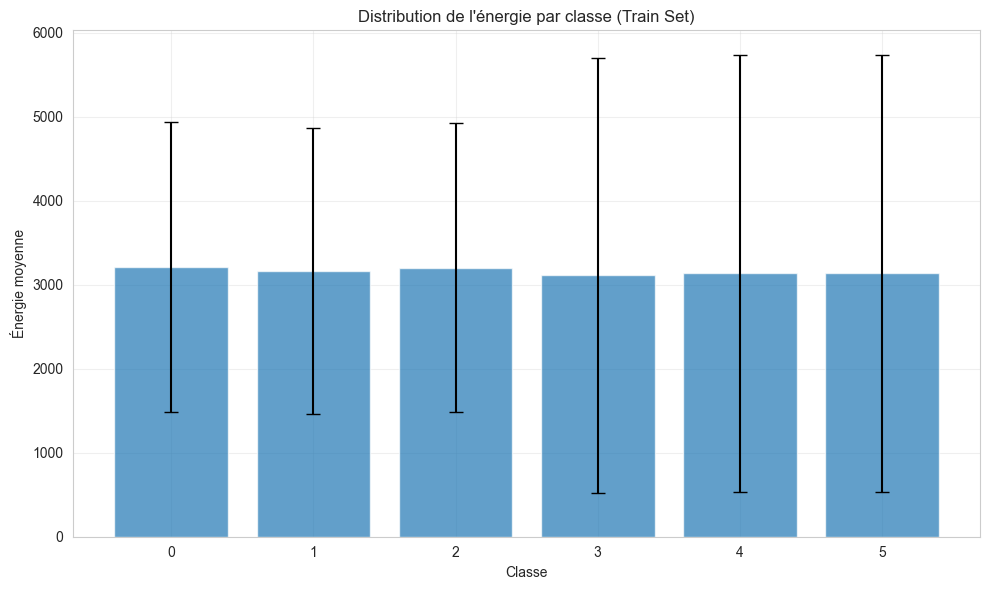

In [8]:
print("="*60)
print("ÉNERGIE MOYENNE PAR CLASSE (Train Set)")
print("="*60)

energy_stats = []
for class_id in normal_classes:
    mask = labels_id_train == class_id
    signals_class = signals_train[mask]
    
    # Calcul de l'énergie
    energy = np.sum(signals_class**2, axis=(1, 2))
    
    energy_stats.append({
        'Classe': class_id,
        'Énergie moyenne': energy.mean(),
        'Écart-type': energy.std(),
        'Min': energy.min(),
        'Max': energy.max(),
        'Nb échantillons': len(signals_class)
    })

energy_df = pd.DataFrame(energy_stats)
print(energy_df.to_string(index=False))

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(energy_df['Classe'], energy_df['Énergie moyenne'], 
        yerr=energy_df['Écart-type'], capsize=5, alpha=0.7)
plt.xlabel('Classe')
plt.ylabel('Énergie moyenne')
plt.title('Distribution de l\'énergie par classe (Train Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
print("="*60)
print("STATISTIQUES CANAL I (In-phase) PAR CLASSE")
print("="*60)

i_stats = []
for class_id in normal_classes:
    mask = labels_id_train == class_id
    i_channel = signals_train[mask, :, 0]  # Canal I
    
    i_stats.append({
        'Classe': class_id,
        'Moyenne': i_channel.mean(),
        'Écart-type': i_channel.std(),
        'Min': i_channel.min(),
        'Max': i_channel.max(),
        'Médiane': np.median(i_channel)
    })

i_df = pd.DataFrame(i_stats)
print(i_df.to_string(index=False))

STATISTIQUES CANAL I (In-phase) PAR CLASSE
 Classe   Moyenne  Écart-type       Min      Max   Médiane
      0 -0.000024    0.885485 -5.653639 5.521568 -0.000042
      1  0.000988    0.879060 -5.981616 5.610048  0.001050
      2  0.000143    0.884299 -5.954816 5.778138  0.000446
      3 -0.000369    0.871766 -6.823913 7.010480 -0.000695
      4  0.000081    0.875080 -6.621037 7.334521 -0.000003
      5  0.000341    0.875097 -6.209929 6.801564  0.000193


In [10]:
print("="*60)
print("STATISTIQUES CANAL Q (Quadrature) PAR CLASSE")
print("="*60)

q_stats = []
for class_id in normal_classes:
    mask = labels_id_train == class_id
    q_channel = signals_train[mask, :, 1]  # Canal Q
    
    q_stats.append({
        'Classe': class_id,
        'Moyenne': q_channel.mean(),
        'Écart-type': q_channel.std(),
        'Min': q_channel.min(),
        'Max': q_channel.max(),
        'Médiane': np.median(q_channel)
    })

q_df = pd.DataFrame(q_stats)
print(q_df.to_string(index=False))

STATISTIQUES CANAL Q (Quadrature) PAR CLASSE
 Classe   Moyenne  Écart-type       Min      Max   Médiane
      0  0.000848    0.885717 -5.746971 5.583323  0.001239
      1  0.000076    0.879307 -5.389212 5.814219  0.000162
      2  0.000284    0.884184 -5.713186 5.832356  0.000405
      3  0.000110    0.871088 -6.296156 6.652425  0.000394
      4 -0.000041    0.875291 -6.671106 6.936680  0.000016
      5 -0.000492    0.874677 -7.071882 6.731125 -0.000208


AMPLITUDE MOYENNE PAR CLASSE
 Classe  Amplitude moyenne  Écart-type      Min      Max
      0           1.102462    0.594267 0.000035 6.569232
      1           1.116470    0.547197 0.000341 6.351666
      2           1.120178    0.555850 0.000256 5.954828
      3           1.025150    0.683986 0.000415 7.368379
      4           1.050555    0.654394 0.000683 7.412248
      5           1.050031    0.654440 0.000886 7.302459


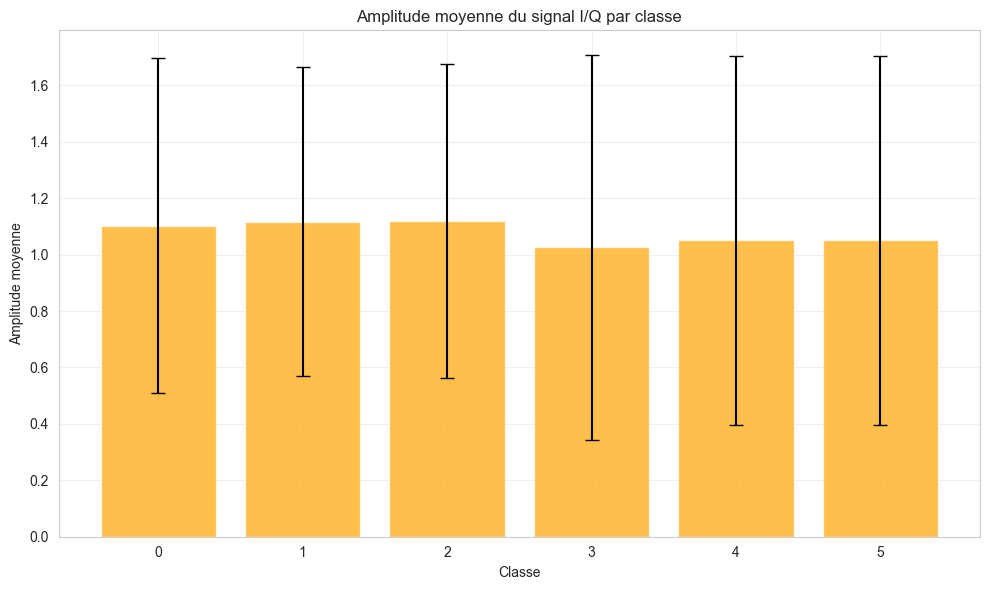

In [11]:
print("="*60)
print("AMPLITUDE MOYENNE PAR CLASSE")
print("="*60)

amplitude_stats = []
for class_id in normal_classes:
    mask = labels_id_train == class_id
    signals_class = signals_train[mask]
    
    # Calcul de l'amplitude
    amplitude = np.sqrt(signals_class[:, :, 0]**2 + signals_class[:, :, 1]**2)
    
    amplitude_stats.append({
        'Classe': class_id,
        'Amplitude moyenne': amplitude.mean(),
        'Écart-type': amplitude.std(),
        'Min': amplitude.min(),
        'Max': amplitude.max()
    })

amplitude_df = pd.DataFrame(amplitude_stats)
print(amplitude_df.to_string(index=False))

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(amplitude_df['Classe'], amplitude_df['Amplitude moyenne'], 
        yerr=amplitude_df['Écart-type'], capsize=5, alpha=0.7, color='orange')
plt.xlabel('Classe')
plt.ylabel('Amplitude moyenne')
plt.title('Amplitude moyenne du signal I/Q par classe')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:

print("="*60)
print("ENTROPIE PAR CLASSE")
print("="*60)

entropy_stats = []
for class_id in normal_classes:
    mask = labels_id_train == class_id
    signals_class = signals_train[mask]
    
    # Calcul de l'entropie sur l'amplitude
    amplitude = np.sqrt(signals_class[:, :, 0]**2 + signals_class[:, :, 1]**2)
    
    # Histogramme pour estimer la distribution
    entropies = []
    for sig in amplitude[:100]:  # Sur un échantillon pour la vitesse
        hist, _ = np.histogram(sig, bins=50, density=True)
        hist = hist[hist > 0]  # Éviter log(0)
        entropies.append(entropy(hist))
    
    entropy_stats.append({
        'Classe': class_id,
        'Entropie moyenne': np.mean(entropies),
        'Écart-type': np.std(entropies)
    })

entropy_df = pd.DataFrame(entropy_stats)
print(entropy_df.to_string(index=False))

ENTROPIE PAR CLASSE
 Classe  Entropie moyenne  Écart-type
      0          3.570297    0.058480
      1          3.457587    0.076557
      2          3.452680    0.094237
      3          3.520905    0.057006
      4          3.498744    0.062085
      5          3.495818    0.049672


In [13]:
print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF - CARACTÉRISTIQUES PAR CLASSE (Train Set)")
print("="*80)

summary = pd.DataFrame({
    'Classe': normal_classes,
    'Énergie': energy_df['Énergie moyenne'].round(1),
    'Amplitude': amplitude_df['Amplitude moyenne'].round(3),
    'Entropie': entropy_df['Entropie moyenne'].round(3),
    'N échantillons': energy_df['Nb échantillons']
})

print(summary.to_string(index=False))
print("="*80)




TABLEAU RÉCAPITULATIF - CARACTÉRISTIQUES PAR CLASSE (Train Set)
 Classe     Énergie  Amplitude  Entropie  N échantillons
      0 3212.500000      1.102     3.570            5143
      1 3166.100098      1.116     3.458            4968
      2 3202.600098      1.120     3.453            5053
      3 3110.399902      1.025     3.521            4867
      4 3137.300049      1.051     3.499            4894
      5 3135.199951      1.050     3.496            5075


In [14]:
print("="*60)
print("SÉLECTION DES SIGNAUX À ANALYSER (SNR = 30 dB)")
print("="*60)

# Sélection des signaux avec SNR=30 pour visualisation claire
high_snr = 30
mask_high_snr = snr_train == high_snr

# Un échantillon par classe
sample_indices = {}
for class_id in normal_classes:
    mask = (labels_id_train == class_id) & mask_high_snr
    indices = np.where(mask)[0]
    if len(indices) > 0:
        sample_indices[class_id] = indices[0]  # Premier échantillon
        print(f"Classe {class_id}: échantillon {indices[0]} sélectionné")

print(f"\nTotal: {len(sample_indices)} signaux sélectionnés (1 par classe)")

SÉLECTION DES SIGNAUX À ANALYSER (SNR = 30 dB)
Classe 0: échantillon 21 sélectionné
Classe 1: échantillon 35 sélectionné
Classe 2: échantillon 17 sélectionné
Classe 3: échantillon 2 sélectionné
Classe 4: échantillon 43 sélectionné
Classe 5: échantillon 11 sélectionné

Total: 6 signaux sélectionnés (1 par classe)


DIAGRAMMES DE CONSTELLATION I/Q


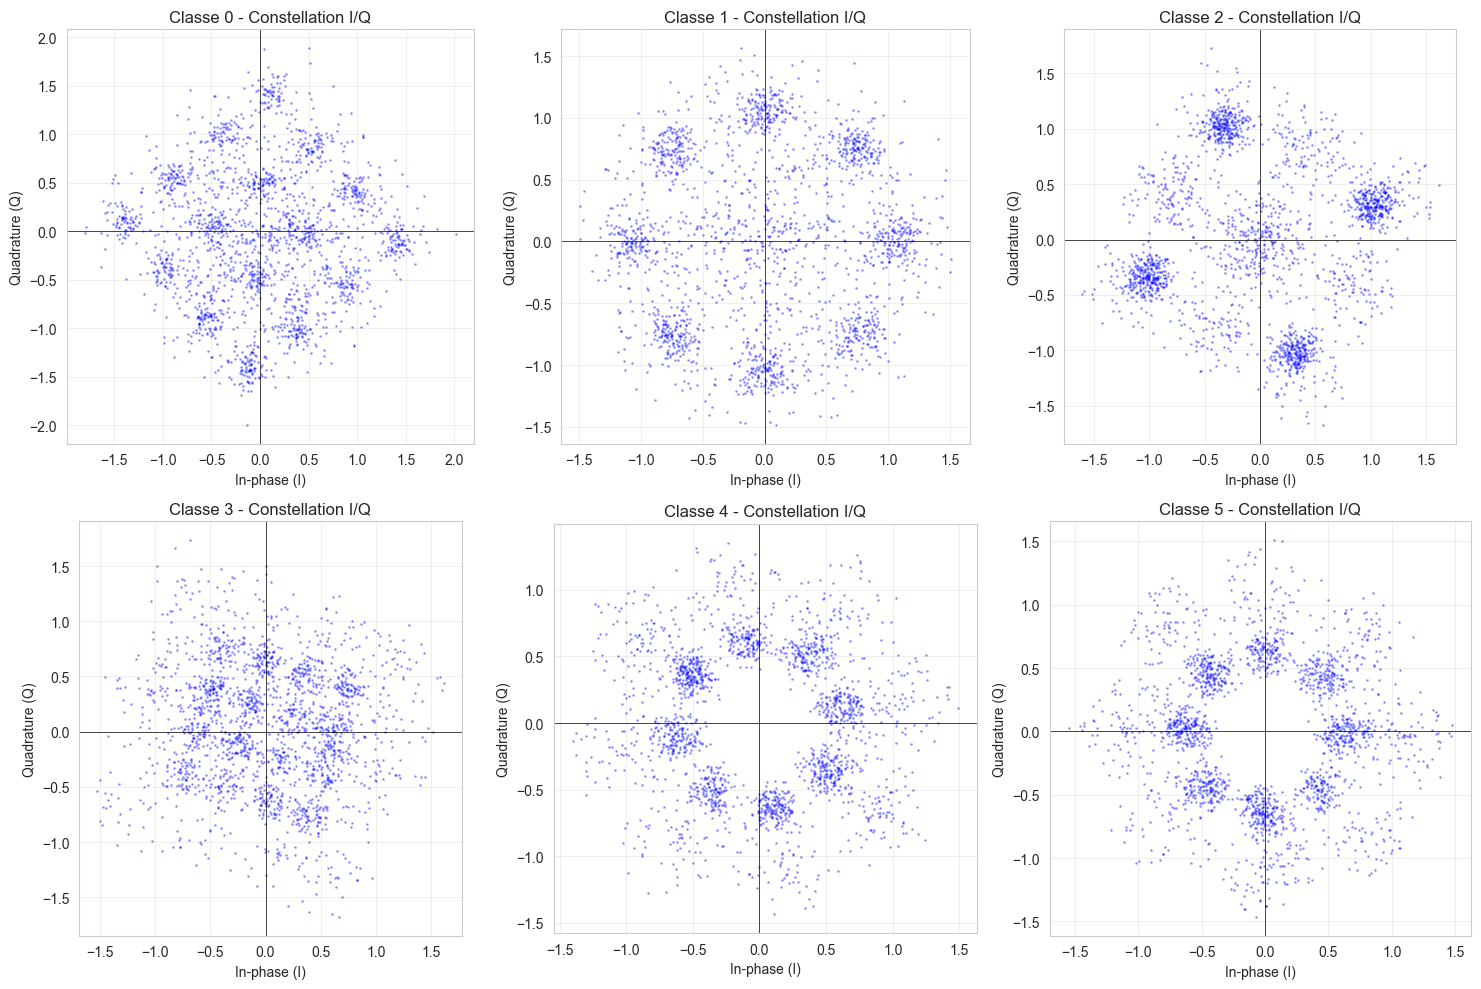

In [ ]:
print("="*60)
print("DIAGRAMMES DE CONSTELLATION I/Q")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, class_id in enumerate(normal_classes):
    ax = axes[idx]
    
    # Récupérer le signal
    signal_idx = sample_indices[class_id]
    signal = signals_train[signal_idx]
    
    # Extraire I et Q
    I = signal[:, 0]
    Q = signal[:, 1]
    
    # Diagramme 
    ax.scatter(I, Q, alpha=0.3, s=1, c='blue')
    ax.set_xlabel('In-phase (I)')
    ax.set_ylabel('Quadrature (Q)')
    ax.set_title(f'Classe {class_id} - Constellation I/Q')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5)
    ax.axvline(x=0, color='k', linewidth=0.5)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

SIGNAUX TEMPORELS I/Q


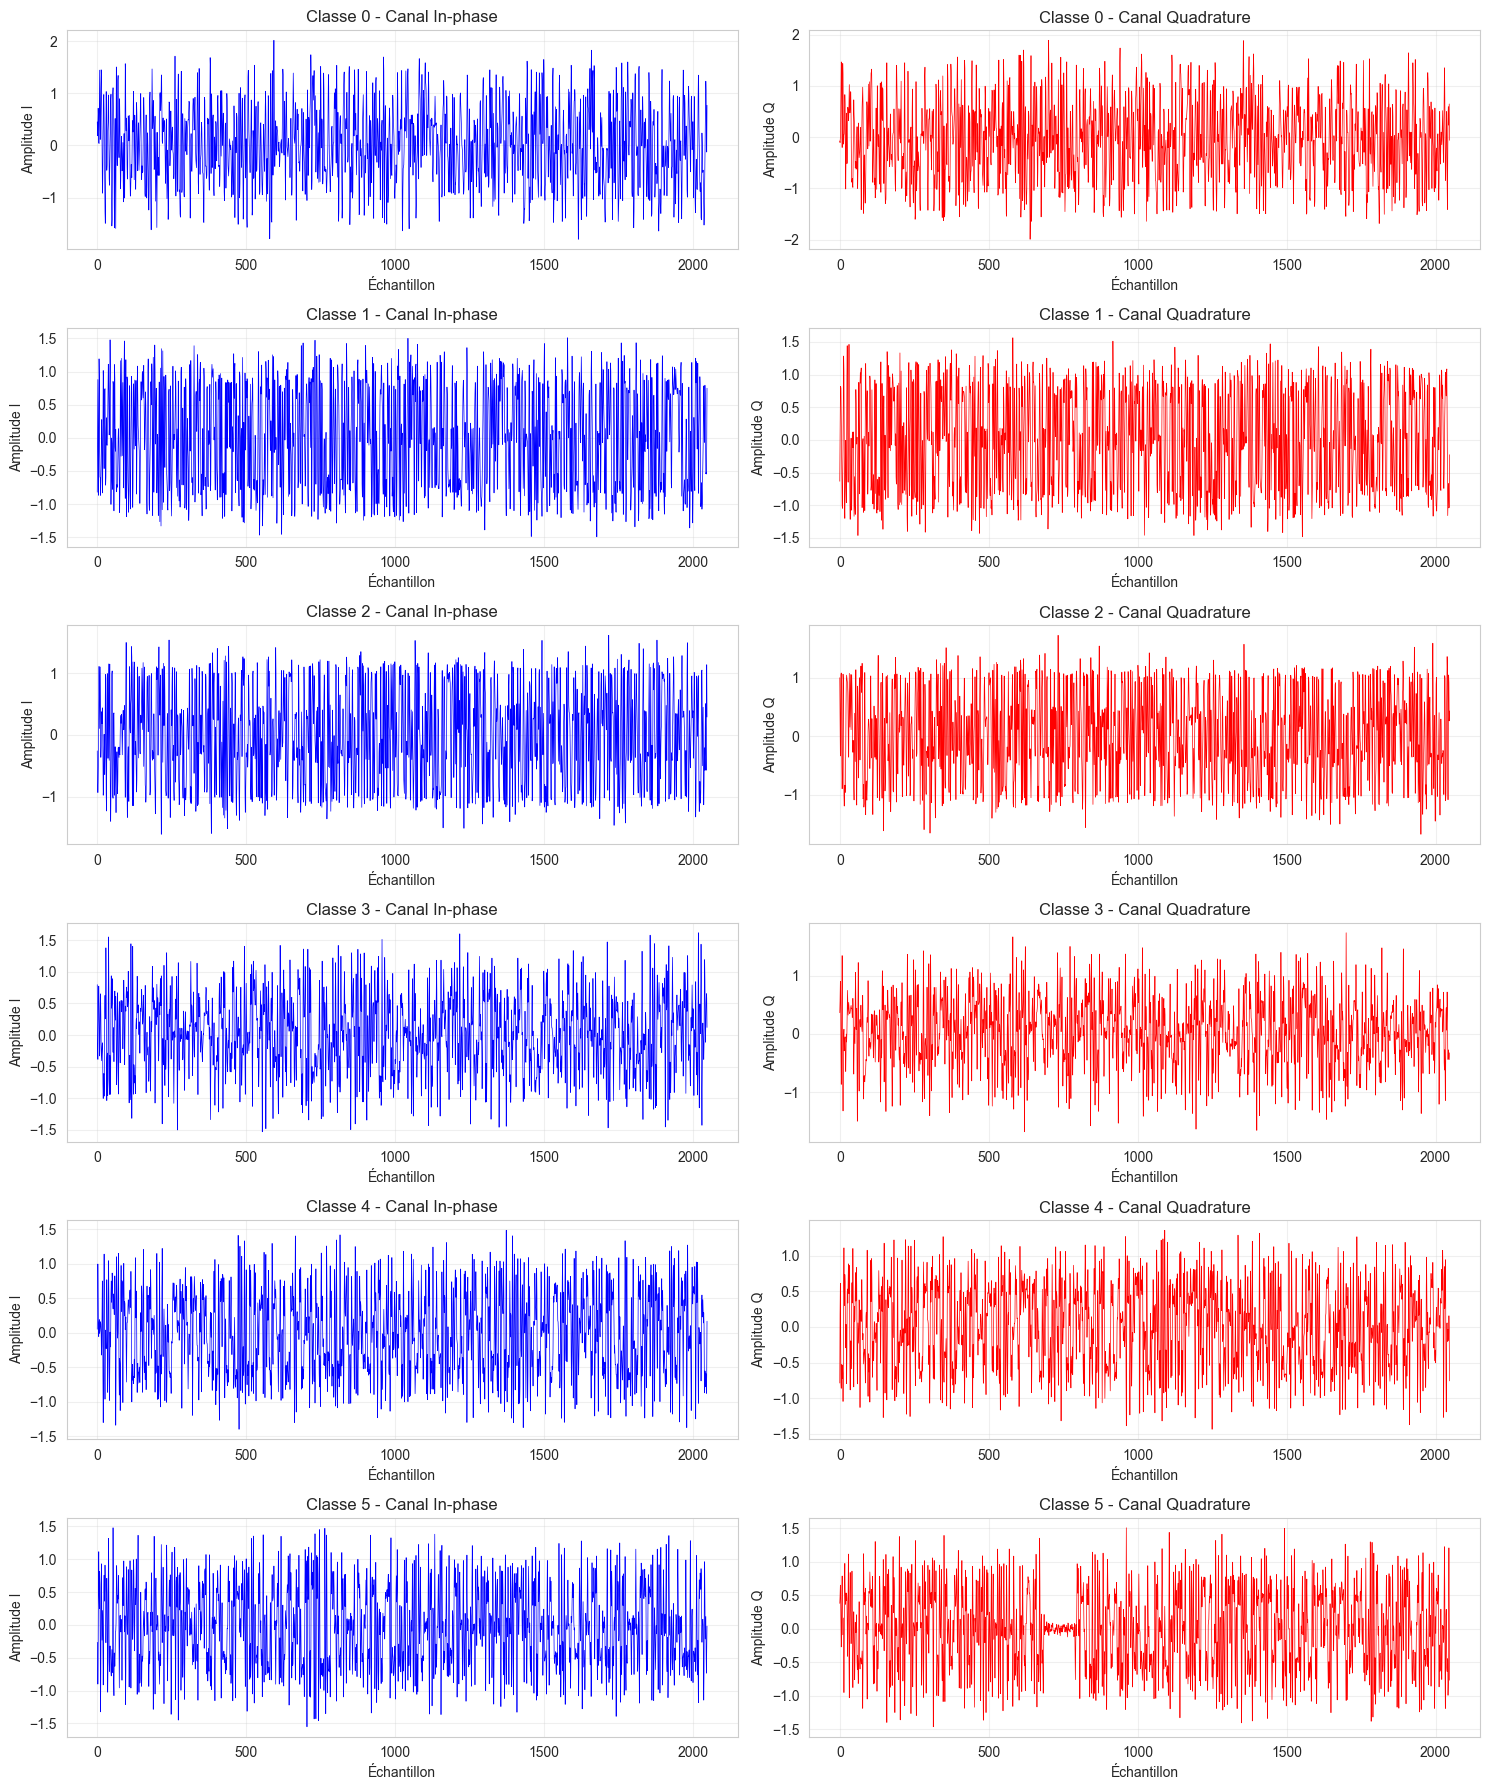

In [16]:
print("="*60)
print("SIGNAUX TEMPORELS I/Q")
print("="*60)

fig, axes = plt.subplots(6, 2, figsize=(15, 18))

for idx, class_id in enumerate(normal_classes):
    # Récupérer le signal
    signal_idx = sample_indices[class_id]
    signal = signals_train[signal_idx]
    
    # Canal I
    ax_i = axes[idx, 0]
    ax_i.plot(signal[:, 0], linewidth=0.5, color='blue')
    ax_i.set_xlabel('Échantillon')
    ax_i.set_ylabel('Amplitude I')
    ax_i.set_title(f'Classe {class_id} - Canal In-phase')
    ax_i.grid(True, alpha=0.3)
    
    # Canal Q
    ax_q = axes[idx, 1]
    ax_q.plot(signal[:, 1], linewidth=0.5, color='red')
    ax_q.set_xlabel('Échantillon')
    ax_q.set_ylabel('Amplitude Q')
    ax_q.set_title(f'Classe {class_id} - Canal Quadrature')
    ax_q.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analyse statistique des anomalies

In [17]:
# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Classes anomalies dans le test set
anomaly_classes = [6, 7, 8]
class_names = {6: 'Anomalie 6', 7: 'Anomalie 7', 8: 'Anomalie 8'}

print("="*60)
print("ANALYSE STATISTIQUE - TEST SET (Classes anomalies 6-8)")
print("="*60)
print(f"Total échantillons test: {len(signals_test)}")
print(f"Classes analysées: {anomaly_classes}")

# Vérification distribution
unique, counts = np.unique(labels_id_test, return_counts=True)
anomaly_counts = {int(k): int(v) for k, v in zip(unique, counts) if k in anomaly_classes}
print(f"Distribution anomalies: {anomaly_counts}")

ANALYSE STATISTIQUE - TEST SET (Classes anomalies 6-8)
Total échantillons test: 2000
Classes analysées: [6, 7, 8]
Distribution anomalies: {6: 331, 7: 313, 8: 328}


ÉNERGIE MOYENNE PAR CLASSE ANOMALIE (Test Set)
 Classe  Énergie moyenne  Écart-type         Min         Max  Nb échantillons
      6      1529.228271  252.911392 1278.742065 2071.106689              331
      7      1569.528442  268.947510 1328.169434 2080.017090              313
      8      1588.053589  276.891174 1268.405884 2068.918701              328


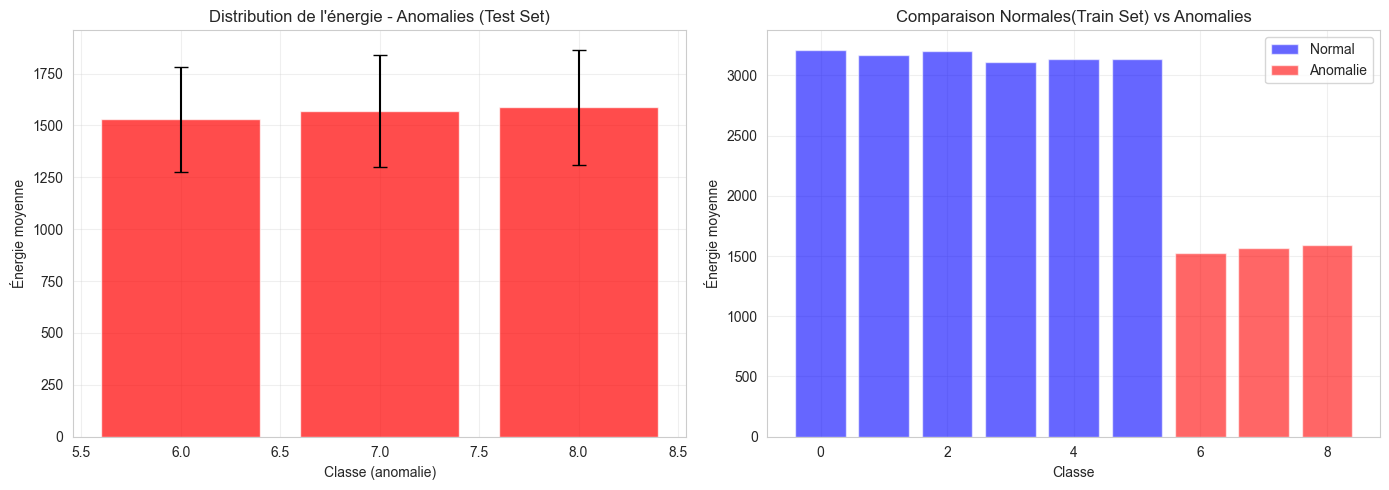


Comparaison:
  - Énergie moyenne normales (0-5): 3160.7
  - Énergie moyenne anomalies (6-8): 1562.3


In [18]:
print("="*60)
print("ÉNERGIE MOYENNE PAR CLASSE ANOMALIE (Test Set)")
print("="*60)

energy_stats_anomaly = []
for class_id in anomaly_classes:
    mask = labels_id_test == class_id
    signals_class = signals_test[mask]
    
    # Calcul de l'énergie
    energy = np.sum(signals_class**2, axis=(1, 2))
    
    energy_stats_anomaly.append({
        'Classe': class_id,
        'Énergie moyenne': energy.mean(),
        'Écart-type': energy.std(),
        'Min': energy.min(),
        'Max': energy.max(),
        'Nb échantillons': len(signals_class)
    })

energy_df_anomaly = pd.DataFrame(energy_stats_anomaly)
print(energy_df_anomaly.to_string(index=False))

# Visualisation comparative avec les normales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Anomalies
ax1.bar(energy_df_anomaly['Classe'], energy_df_anomaly['Énergie moyenne'], 
        yerr=energy_df_anomaly['Écart-type'], capsize=5, alpha=0.7, color='red')
ax1.set_xlabel('Classe (anomalie)')
ax1.set_ylabel('Énergie moyenne')
ax1.set_title('Distribution de l\'énergie - Anomalies (Test Set)')
ax1.grid(True, alpha=0.3)

# Comparaison avec normales
all_energies = pd.concat([
    pd.DataFrame({'Classe': energy_df['Classe'], 'Énergie': energy_df['Énergie moyenne'], 'Type': 'Normal'}),
    pd.DataFrame({'Classe': energy_df_anomaly['Classe'], 'Énergie': energy_df_anomaly['Énergie moyenne'], 'Type': 'Anomalie'})
])
colors_map = {'Normal': 'blue', 'Anomalie': 'red'}
for type_name in ['Normal', 'Anomalie']:
    data = all_energies[all_energies['Type'] == type_name]
    ax2.bar(data['Classe'], data['Énergie'], alpha=0.6, label=type_name, color=colors_map[type_name])
ax2.set_xlabel('Classe')
ax2.set_ylabel('Énergie moyenne')
ax2.set_title('Comparaison Normales(Train Set) vs Anomalies')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparaison:")
print(f"  - Énergie moyenne normales (0-5): {energy_df['Énergie moyenne'].mean():.1f}")
print(f"  - Énergie moyenne anomalies (6-8): {energy_df_anomaly['Énergie moyenne'].mean():.1f}")

In [19]:
print("="*60)
print("STATISTIQUES CANAL I (In-phase) - ANOMALIES")
print("="*60)

i_stats_anomaly = []
for class_id in anomaly_classes:
    mask = labels_id_test == class_id
    i_channel = signals_test[mask, :, 0]
    
    i_stats_anomaly.append({
        'Classe': class_id,
        'Moyenne': i_channel.mean(),
        'Écart-type': i_channel.std(),
        'Min': i_channel.min(),
        'Max': i_channel.max(),
        'Médiane': np.median(i_channel)
    })

i_df_anomaly = pd.DataFrame(i_stats_anomaly)
print(i_df_anomaly.to_string(index=False))

STATISTIQUES CANAL I (In-phase) - ANOMALIES
 Classe   Moyenne  Écart-type       Min      Max   Médiane
      6 -0.000953    0.611377 -2.677994 2.904201 -0.002823
      7  0.001371    0.620155 -2.635004 2.684088  0.002638
      8 -0.000192    0.622505 -2.876601 2.640984  0.000330


In [20]:
print("="*60)
print("STATISTIQUES CANAL Q (Quadrature) - ANOMALIES")
print("="*60)

q_stats_anomaly = []
for class_id in anomaly_classes:
    mask = labels_id_test == class_id
    q_channel = signals_test[mask, :, 1]
    
    q_stats_anomaly.append({
        'Classe': class_id,
        'Moyenne': q_channel.mean(),
        'Écart-type': q_channel.std(),
        'Min': q_channel.min(),
        'Max': q_channel.max(),
        'Médiane': np.median(q_channel)
    })

q_df_anomaly = pd.DataFrame(q_stats_anomaly)
print(q_df_anomaly.to_string(index=False))

STATISTIQUES CANAL Q (Quadrature) - ANOMALIES
 Classe   Moyenne  Écart-type       Min      Max   Médiane
      6 -0.000802    0.610664 -2.700107 2.880924 -0.002254
      7  0.001292    0.617880 -2.526936 2.924516  0.003073
      8  0.000126    0.622820 -2.642503 2.766648  0.000434


AMPLITUDE MOYENNE - ANOMALIES
 Classe  Amplitude moyenne  Écart-type      Min      Max
      6           0.777097    0.377908 0.001686 3.190271
      7           0.814687    0.320401 0.002789 2.949337
      8           0.791688    0.385548 0.001641 2.965079


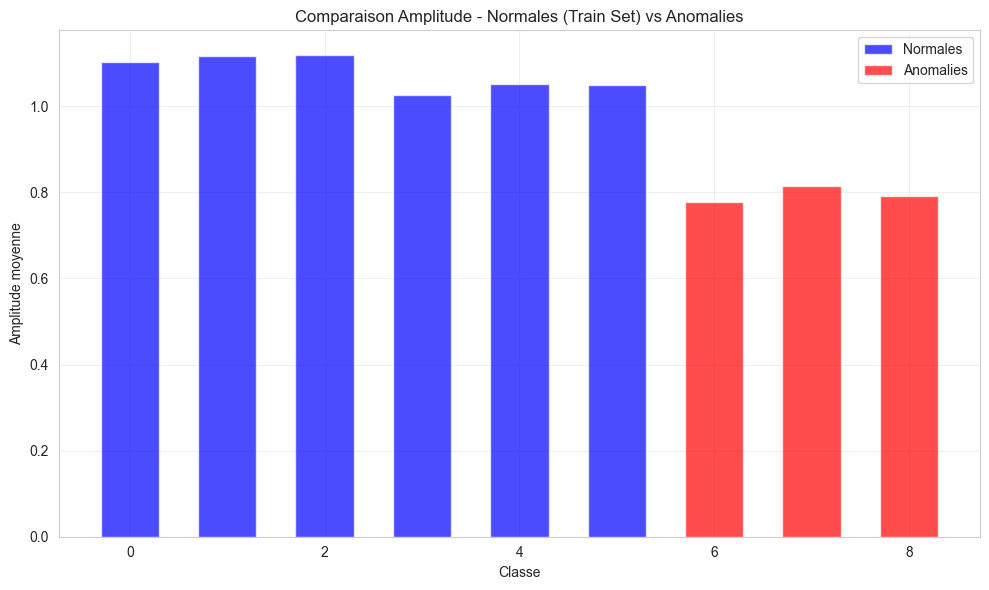

In [21]:
print("="*60)
print("AMPLITUDE MOYENNE - ANOMALIES")
print("="*60)

amplitude_stats_anomaly = []
for class_id in anomaly_classes:
    mask = labels_id_test == class_id
    signals_class = signals_test[mask]
    
    # Calcul de l'amplitude
    amplitude = np.sqrt(signals_class[:, :, 0]**2 + signals_class[:, :, 1]**2)
    
    amplitude_stats_anomaly.append({
        'Classe': class_id,
        'Amplitude moyenne': amplitude.mean(),
        'Écart-type': amplitude.std(),
        'Min': amplitude.min(),
        'Max': amplitude.max()
    })

amplitude_df_anomaly = pd.DataFrame(amplitude_stats_anomaly)
print(amplitude_df_anomaly.to_string(index=False))

# Comparaison visuelle
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(energy_df) + len(energy_df_anomaly))
width = 0.6

# Normales
ax.bar(energy_df['Classe'], amplitude_df['Amplitude moyenne'], 
       width, alpha=0.7, color='blue', label='Normales')
# Anomalies
ax.bar(amplitude_df_anomaly['Classe'], amplitude_df_anomaly['Amplitude moyenne'], 
       width, alpha=0.7, color='red', label='Anomalies')

ax.set_xlabel('Classe')
ax.set_ylabel('Amplitude moyenne')
ax.set_title('Comparaison Amplitude - Normales (Train Set) vs Anomalies')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:

print("="*60)
print("ENTROPIE - ANOMALIES")
print("="*60)

entropy_stats_anomaly = []
for class_id in anomaly_classes:
    mask = labels_id_test == class_id
    signals_class = signals_test[mask]
    
    # Calcul de l'entropie sur l'amplitude
    amplitude = np.sqrt(signals_class[:, :, 0]**2 + signals_class[:, :, 1]**2)
    
    # Sur échantillon pour vitesse
    entropies = []
    for sig in amplitude[:100]:
        hist, _ = np.histogram(sig, bins=50, density=True)
        hist = hist[hist > 0]
        entropies.append(entropy(hist))
    
    entropy_stats_anomaly.append({
        'Classe': class_id,
        'Entropie moyenne': np.mean(entropies),
        'Écart-type': np.std(entropies)
    })

entropy_df_anomaly = pd.DataFrame(entropy_stats_anomaly)
print(entropy_df_anomaly.to_string(index=False))

ENTROPIE - ANOMALIES
 Classe  Entropie moyenne  Écart-type
      6          3.555491    0.056644
      7          3.539433    0.050268
      8          3.534840    0.040901


In [23]:
print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF - ANOMALIES (Test Set)")
print("="*80)

summary_anomaly = pd.DataFrame({
    'Classe': anomaly_classes,
    'Énergie': energy_df_anomaly['Énergie moyenne'].round(1),
    'Amplitude': amplitude_df_anomaly['Amplitude moyenne'].round(3),
    'Entropie': entropy_df_anomaly['Entropie moyenne'].round(3),
    'N échantillons': energy_df_anomaly['Nb échantillons']
})

print(summary_anomaly.to_string(index=False))
print("="*80)

# Comparaison globale
print("\n" + "="*80)
print("COMPARAISON NORMALES vs ANOMALIES")
print("="*80)

comparison_table = pd.DataFrame({
    'Métrique': ['Énergie moyenne', 'Amplitude moyenne', 'Entropie moyenne'],
    'Normales (0-5)': [
        f"{summary['Énergie'].mean():.1f}",
        f"{summary['Amplitude'].mean():.3f}",
        f"{summary['Entropie'].mean():.3f}"
    ],
    'Anomalies (6-8)': [
        f"{summary_anomaly['Énergie'].mean():.1f}",
        f"{summary_anomaly['Amplitude'].mean():.3f}",
        f"{summary_anomaly['Entropie'].mean():.3f}"
    ]
})

print(comparison_table.to_string(index=False))
print("="*80)


TABLEAU RÉCAPITULATIF - ANOMALIES (Test Set)
 Classe     Énergie  Amplitude  Entropie  N échantillons
      6 1529.199951      0.777     3.555             331
      7 1569.500000      0.815     3.539             313
      8 1588.099976      0.792     3.535             328

COMPARAISON NORMALES vs ANOMALIES
         Métrique Normales (0-5) Anomalies (6-8)
  Énergie moyenne         3160.7          1562.3
Amplitude moyenne          1.077           0.795
 Entropie moyenne          3.499           3.543


In [24]:
print("="*60)
print("SÉLECTION DES SIGNAUX ANOMALIES À VISUALISER (SNR = 30 dB)")
print("="*60)

# Sélection SNR=30 pour anomalies
high_snr = 30
mask_high_snr_test = snr_test == high_snr

# Un échantillon par classe anomalie
sample_indices_anomaly = {}
for class_id in anomaly_classes:
    mask = (labels_id_test == class_id) & mask_high_snr_test
    indices = np.where(mask)[0]
    if len(indices) > 0:
        sample_indices_anomaly[class_id] = indices[0]
        print(f"Anomalie {class_id}: échantillon {indices[0]} sélectionné")
    else:
        print(f"Anomalie {class_id}: AUCUN échantillon avec SNR=30, utilisation premier disponible")
        mask = labels_id_test == class_id
        indices = np.where(mask)[0]
        sample_indices_anomaly[class_id] = indices[0]

print(f"\nTotal: {len(sample_indices_anomaly)} signaux anomalies sélectionnés")

SÉLECTION DES SIGNAUX ANOMALIES À VISUALISER (SNR = 30 dB)
Anomalie 6: échantillon 15 sélectionné
Anomalie 7: échantillon 31 sélectionné
Anomalie 8: échantillon 0 sélectionné

Total: 3 signaux anomalies sélectionnés


DIAGRAMMES DE CONSTELLATION I/Q - ANOMALIES


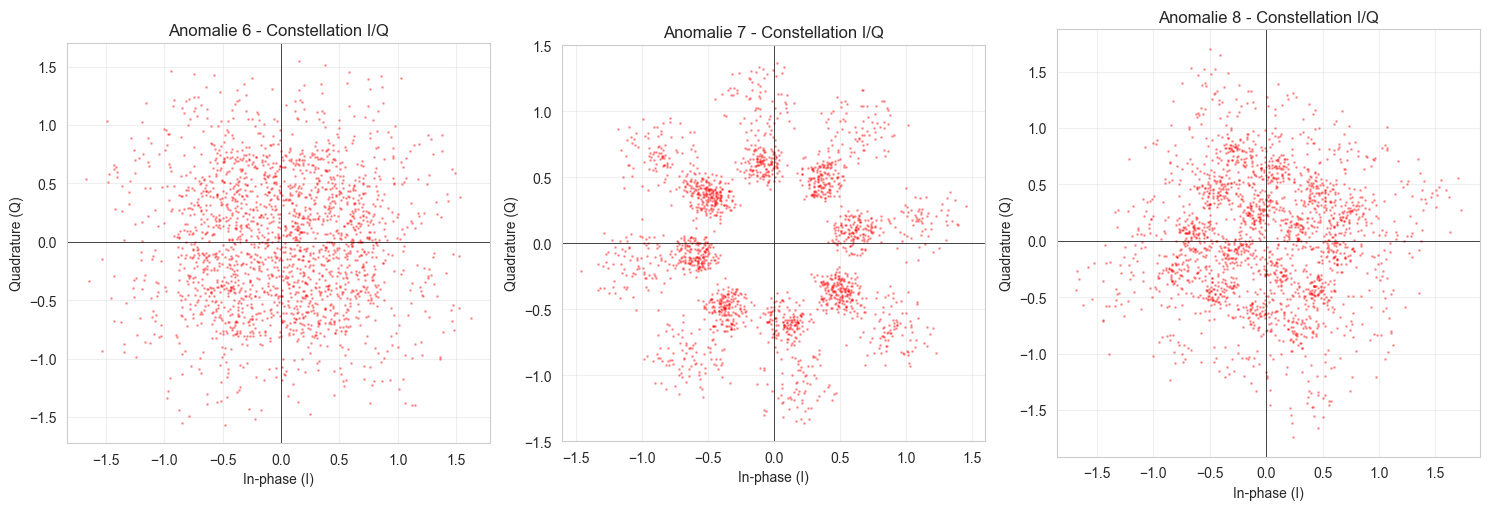

In [25]:
print("="*60)
print("DIAGRAMMES DE CONSTELLATION I/Q - ANOMALIES")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, class_id in enumerate(anomaly_classes):
    ax = axes[idx]
    
    # Récupérer le signal anomalie
    signal_idx = sample_indices_anomaly[class_id]
    signal = signals_test[signal_idx]
    
    # Extraire I et Q
    I = signal[:, 0]
    Q = signal[:, 1]
    
    # Diagramme de constellation
    ax.scatter(I, Q, alpha=0.3, s=1, c='red')
    ax.set_xlabel('In-phase (I)')
    ax.set_ylabel('Quadrature (Q)')
    ax.set_title(f'Anomalie {class_id} - Constellation I/Q')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5)
    ax.axvline(x=0, color='k', linewidth=0.5)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

SIGNAUX TEMPORELS I/Q - ANOMALIES


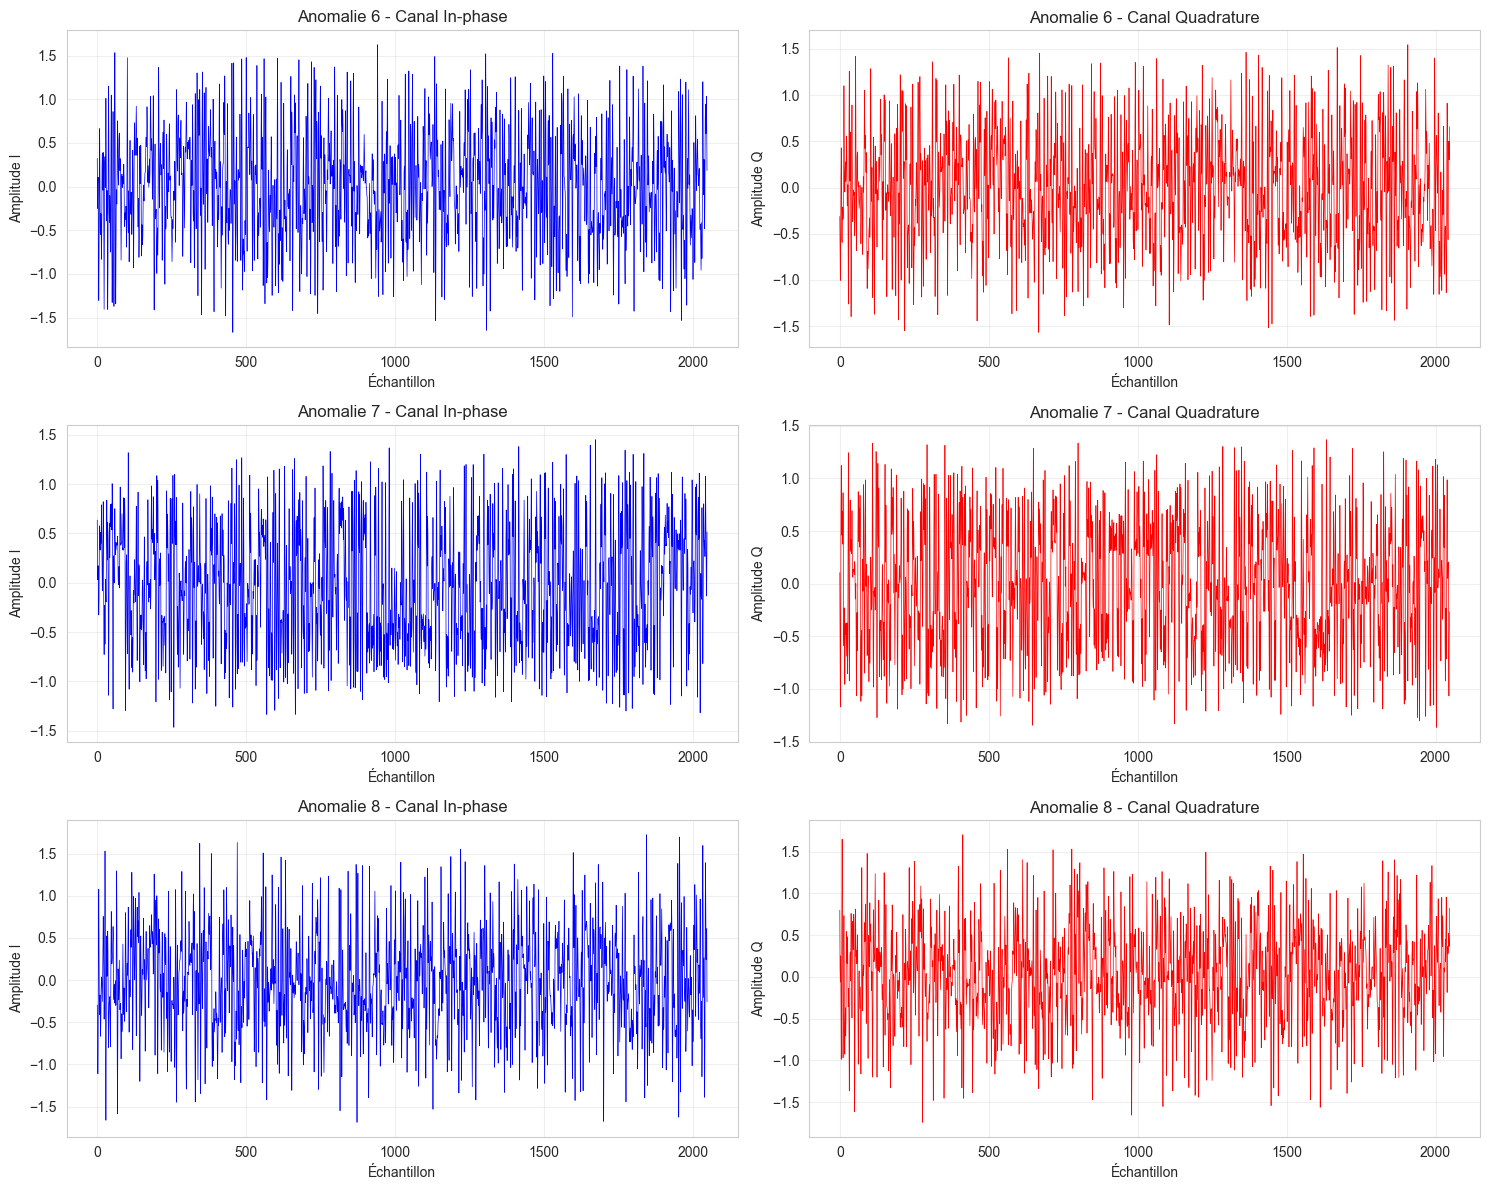

In [26]:
print("="*60)
print("SIGNAUX TEMPORELS I/Q - ANOMALIES")
print("="*60)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

for idx, class_id in enumerate(anomaly_classes):
    # Récupérer le signal
    signal_idx = sample_indices_anomaly[class_id]
    signal = signals_test[signal_idx]
    
    # Canal I
    ax_i = axes[idx, 0]
    ax_i.plot(signal[:, 0], linewidth=0.5, color='blue')
    ax_i.set_xlabel('Échantillon')
    ax_i.set_ylabel('Amplitude I')
    ax_i.set_title(f'Anomalie {class_id} - Canal In-phase')
    ax_i.grid(True, alpha=0.3)
    
    # Canal Q
    ax_q = axes[idx, 1]
    ax_q.plot(signal[:, 1], linewidth=0.5, color='red')
    ax_q.set_xlabel('Échantillon')
    ax_q.set_ylabel('Amplitude Q')
    ax_q.set_title(f'Anomalie {class_id} - Canal Quadrature')
    ax_q.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

CONSTELLATIONS I/Q - NORMALES vs ANOMALIES


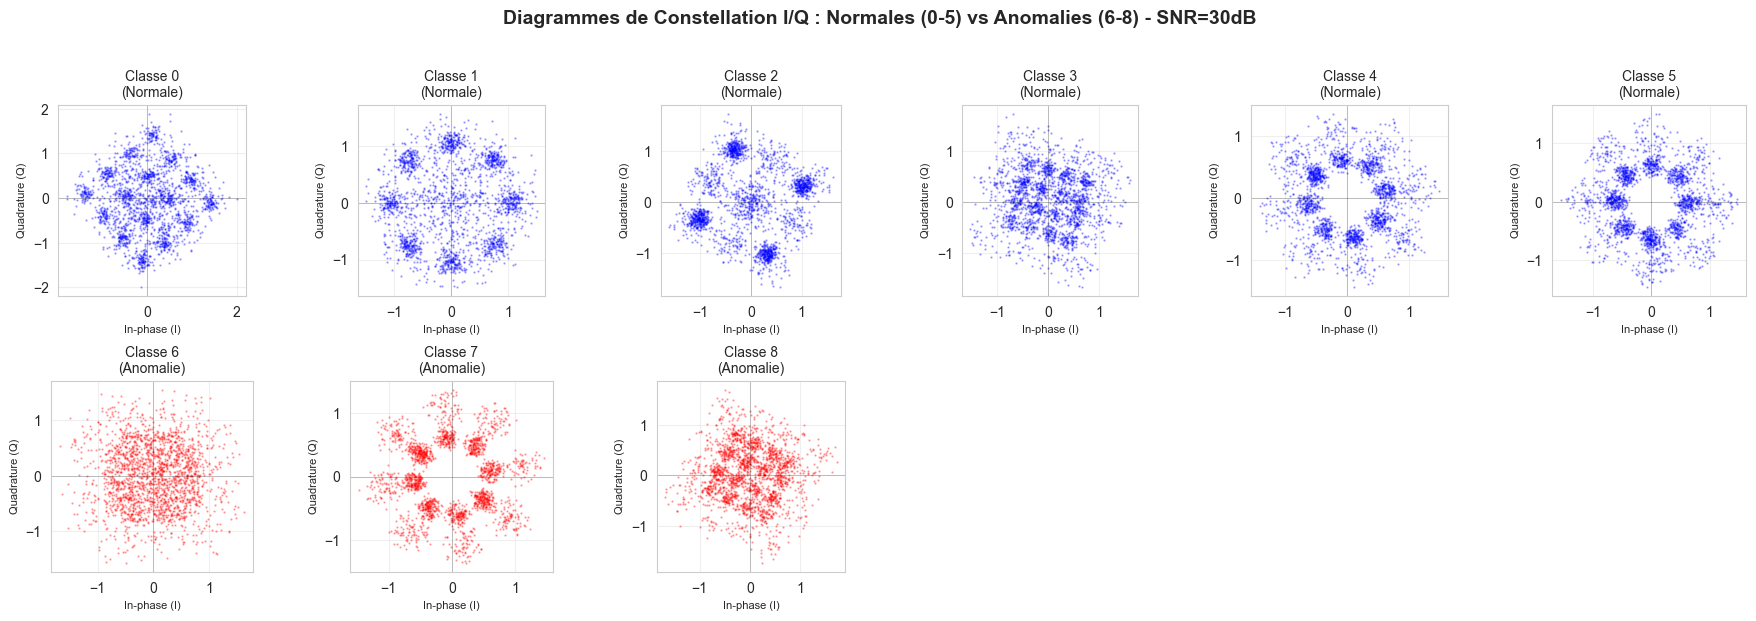

In [27]:
print("="*60)
print("CONSTELLATIONS I/Q - NORMALES vs ANOMALIES")
print("="*60)

fig = plt.figure(figsize=(18, 6))

# Constellations - Normales (classes 0-5)
for idx, class_id in enumerate(normal_classes):
    ax = plt.subplot(2, 6, idx + 1)
    signal_idx = sample_indices[class_id]
    signal = signals_train[signal_idx]
    ax.scatter(signal[:, 0], signal[:, 1], alpha=0.3, s=0.5, c='blue')
    ax.set_title(f'Classe {class_id}\n(Normale)', fontsize=10)
    ax.set_xlabel('In-phase (I)', fontsize=8)
    ax.set_ylabel('Quadrature (Q)', fontsize=8)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)

# Constellations - Anomalies (classes 6-8)
for idx, class_id in enumerate(anomaly_classes):
    ax = plt.subplot(2, 6, idx + 7)
    signal_idx = sample_indices_anomaly[class_id]
    signal = signals_test[signal_idx]
    ax.scatter(signal[:, 0], signal[:, 1], alpha=0.3, s=0.5, c='red')
    ax.set_title(f'Classe {class_id}\n(Anomalie)', fontsize=10)
    ax.set_xlabel('In-phase (I)', fontsize=8)
    ax.set_ylabel('Quadrature (Q)', fontsize=8)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)

plt.suptitle('Diagrammes de Constellation I/Q : Normales (0-5) vs Anomalies (6-8) - SNR=30dB', 
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

COMPARAISON ÉNERGIE : TRAIN SET vs TEST SET

1. TRAIN SET (par classe)
  Classe 0: 3212.5 ± 1729.3
  Classe 1: 3166.1 ± 1706.1
  Classe 2: 3202.6 ± 1723.0
  Classe 3: 3110.4 ± 2592.7
  Classe 4: 3137.3 ± 2604.3
  Classe 5: 3135.2 ± 2605.6

  MOYENNE GLOBALE TRAIN: 3161.2

2. TEST SET - NORMALES (par classe)
  Classe 0: 2202.4 ± 185.9
  Classe 1: 2194.1 ± 185.1
  Classe 2: 2189.1 ± 181.1
  Classe 3: 1557.6 ± 267.1
  Classe 4: 1543.9 ± 253.7
  Classe 5: 1551.0 ± 261.1

  MOYENNE GLOBALE TEST (normales): 1877.7

3. TEST SET - ANOMALIES (par classe)
  Classe 6: 1529.2 ± 252.9
  Classe 7: 1569.5 ± 268.9
  Classe 8: 1588.1 ± 276.9

  MOYENNE GLOBALE TEST (anomalies): 1562.1

TABLEAU RÉCAPITULATIF
         Dataset  Énergie moyenne  Écart-type  Nb échantillons
Train (normales)      3161.234131 2200.348145            30000
 Test (normales)      1877.673828  393.143616             1028
Test (anomalies)      1562.056152  267.505432              972


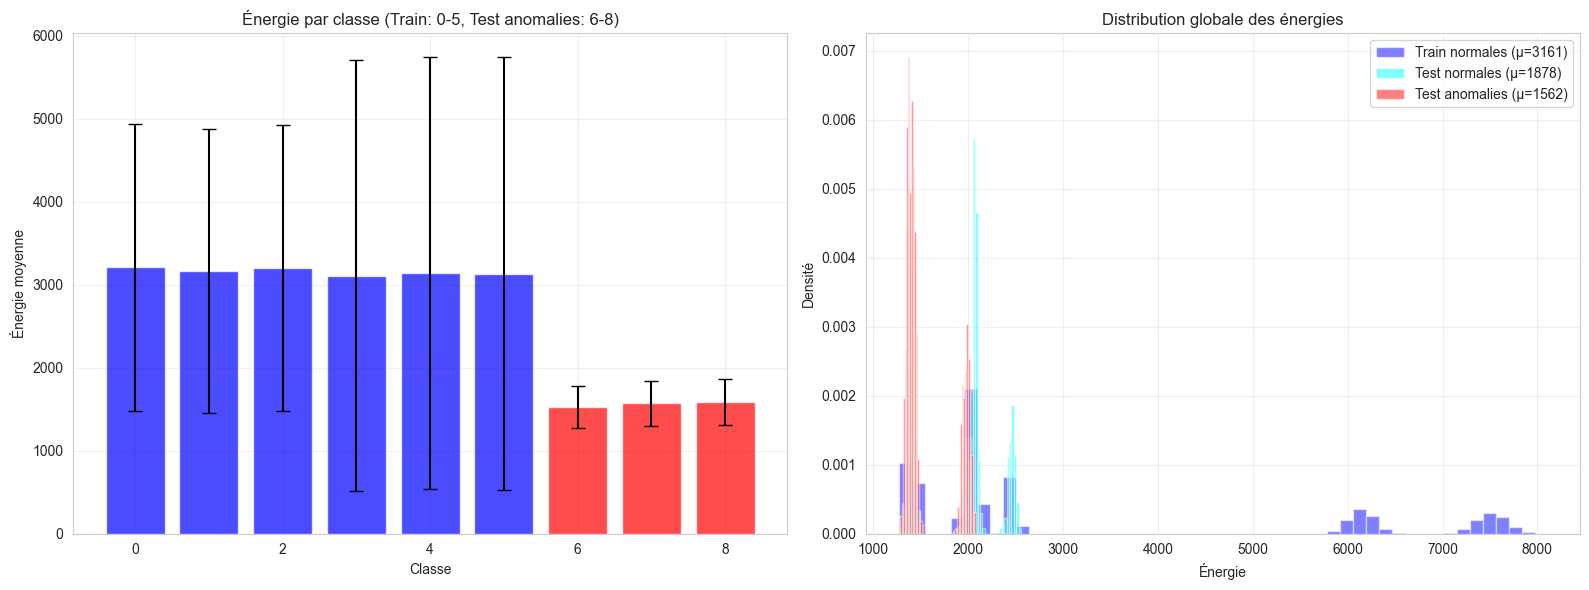

In [ ]:

print("="*80)
print("COMPARAISON ÉNERGIE : TRAIN SET vs TEST SET")
print("="*80)

# --- 1. TRAIN SET - Par classe ---
print("\n1. TRAIN SET (par classe)")
energy_stats_train = []
for class_id in range(6):
    mask = labels_id_train == class_id
    signals_class = signals_train[mask]
    energy = np.sum(signals_class**2, axis=(1, 2))
    
    energy_stats_train.append({
        'Classe': class_id,
        'Énergie moyenne': energy.mean(),
        'Écart-type': energy.std(),
        'Nb échantillons': len(signals_class)
    })
    print(f"  Classe {class_id}: {energy.mean():.1f} ± {energy.std():.1f}")

# Énergie globale train
energy_train_global = np.sum(signals_train**2, axis=(1, 2))
print(f"\n  MOYENNE GLOBALE TRAIN: {energy_train_global.mean():.1f}")

# --- 2. TEST SET - Calcul des masques ---
normal_mask = labels_id_test <= 5       # classes normales 0-5
anomaly_mask = labels_id_test >= 6      # classes anomalies 6-8

# Énergie globale test
energies_test = np.sum(signals_test**2, axis=(1, 2))

# --- 2a. TEST SET - Normales par classe ---
print("\n2. TEST SET - NORMALES (par classe)")
energy_stats_test_normal = []
for class_id in range(6):
    mask = labels_id_test == class_id
    if mask.sum() > 0:
        signals_class = signals_test[mask]
        energy = np.sum(signals_class**2, axis=(1, 2))
        
        energy_stats_test_normal.append({
            'Classe': class_id,
            'Énergie moyenne': energy.mean(),
            'Écart-type': energy.std(),
            'Nb échantillons': len(signals_class)
        })
        print(f"  Classe {class_id}: {energy.mean():.1f} ± {energy.std():.1f}")

energies_test_normal = energies_test[normal_mask]
print(f"\n  MOYENNE GLOBALE TEST (normales): {energies_test_normal.mean():.1f}")

# --- 2b. TEST SET - Anomalies par classe ---
print("\n3. TEST SET - ANOMALIES (par classe)")
energy_stats_test_anomaly = []
for class_id in range(6, 9):
    mask = labels_id_test == class_id
    if mask.sum() > 0:
        signals_class = signals_test[mask]
        energy = np.sum(signals_class**2, axis=(1, 2))
        
        energy_stats_test_anomaly.append({
            'Classe': class_id,
            'Énergie moyenne': energy.mean(),
            'Écart-type': energy.std(),
            'Nb échantillons': len(signals_class)
        })
        print(f"  Classe {class_id}: {energy.mean():.1f} ± {energy.std():.1f}")

energies_test_anomaly = energies_test[anomaly_mask]
print(f"\n  MOYENNE GLOBALE TEST (anomalies): {energies_test_anomaly.mean():.1f}")

# --- 4. TABLEAU RÉCAPITULATIF ---
print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF")
print("="*80)

recap_df = pd.DataFrame({
    'Dataset': ['Train (normales)', 'Test (normales)', 'Test (anomalies)'],
    'Énergie moyenne': [
        energy_train_global.mean(),
        energies_test_normal.mean(),
        energies_test_anomaly.mean()
    ],
    'Écart-type': [
        energy_train_global.std(),
        energies_test_normal.std(),
        energies_test_anomaly.std()
    ],
    'Nb échantillons': [
        len(energy_train_global),
        normal_mask.sum(),
        anomaly_mask.sum()
    ]
})

print(recap_df.to_string(index=False))

# --- 5. VISUALISATION COMPARATIVE ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Distribution par classe
ax1 = axes[0]
all_classes = list(range(9))
all_energies = []
all_stds = []
colors = []

# Train normales 0-5
for stats in energy_stats_train:
    all_energies.append(stats['Énergie moyenne'])
    all_stds.append(stats['Écart-type'])
    colors.append('blue')

# Test anomalies 6-8
for stats in energy_stats_test_anomaly:
    all_energies.append(stats['Énergie moyenne'])
    all_stds.append(stats['Écart-type'])
    colors.append('red')

ax1.bar(all_classes, all_energies, yerr=all_stds, capsize=5, alpha=0.7, color=colors)
ax1.set_xlabel('Classe')
ax1.set_ylabel('Énergie moyenne')
ax1.set_title('Énergie par classe (Train: 0-5, Test anomalies: 6-8)')
ax1.grid(True, alpha=0.3)

# Graphique 2: Distributions globales
ax2 = axes[1]
ax2.hist(energy_train_global, bins=50, alpha=0.5, label=f'Train normales (μ={energy_train_global.mean():.0f})', 
         color='blue', density=True)
ax2.hist(energies_test_normal, bins=50, alpha=0.5, label=f'Test normales (μ={energies_test_normal.mean():.0f})', 
         color='cyan', density=True)
ax2.hist(energies_test_anomaly, bins=50, alpha=0.5, label=f'Test anomalies (μ={energies_test_anomaly.mean():.0f})', 
         color='red', density=True)
ax2.set_xlabel('Énergie')
ax2.set_ylabel('Densité')
ax2.set_title('Distribution globale des énergies')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


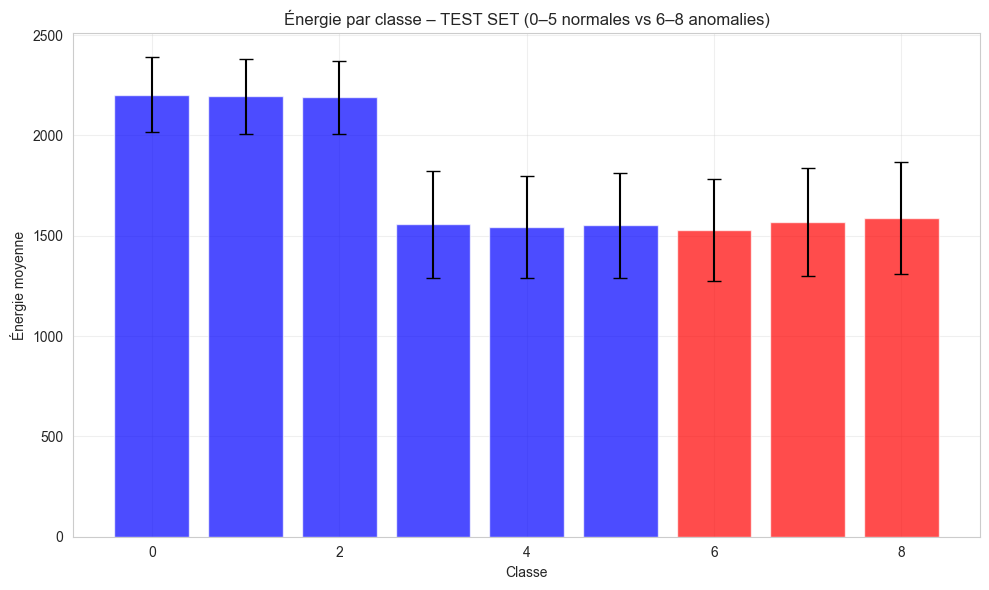

In [31]:
#Visualisation Test set 
fig, ax = plt.subplots(figsize=(10, 6))

classes_test = []
energies_test_means = []
energies_test_stds = []
colors = []

# Classes normales (0–5)
for stats in energy_stats_test_normal:
    classes_test.append(stats['Classe'])
    energies_test_means.append(stats['Énergie moyenne'])
    energies_test_stds.append(stats['Écart-type'])
    colors.append('blue')

# Classes anomalies (6–8)
for stats in energy_stats_test_anomaly:
    classes_test.append(stats['Classe'])
    energies_test_means.append(stats['Énergie moyenne'])
    energies_test_stds.append(stats['Écart-type'])
    colors.append('red')

ax.bar(
    classes_test,
    energies_test_means,
    yerr=energies_test_stds,
    capsize=5,
    alpha=0.7,
    color=colors
)

ax.set_xlabel('Classe')
ax.set_ylabel('Énergie moyenne')
ax.set_title('Énergie par classe – TEST SET (0–5 normales vs 6–8 anomalies)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


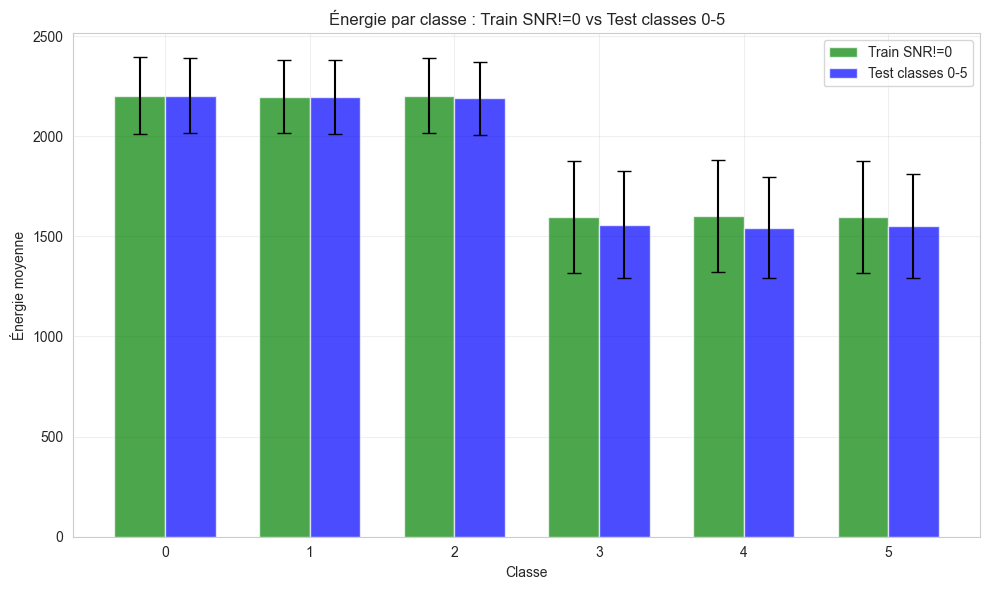

In [35]:
# Visualisation comparée par classe : Train SNR!=0 vs Test classes 0-5
fig, ax = plt.subplots(figsize=(10, 6))

classes_plot = list(range(6))  # 0 à 5
means_train = []
stds_train = []
means_test = []
stds_test = []

# Préparer les stats pour le train filtré (SNR!=0)
for class_id in classes_plot:
    mask_train_class = (labels_id_train == class_id) & (snr_train != 0)
    signals_class = signals_train[mask_train_class]
    energy_class = np.sum(signals_class**2, axis=(1,2))
    
    means_train.append(energy_class.mean() if len(energy_class)>0 else 0)
    stds_train.append(energy_class.std() if len(energy_class)>0 else 0)

# Préparer les stats pour le test normal (classes 0-5)
for class_id in classes_plot:
    mask_test_class = labels_id_test == class_id
    signals_class = signals_test[mask_test_class]
    energy_class = np.sum(signals_class**2, axis=(1,2))
    
    means_test.append(energy_class.mean() if len(energy_class)>0 else 0)
    stds_test.append(energy_class.std() if len(energy_class)>0 else 0)

# Largeur des barres
width = 0.35
x = np.arange(len(classes_plot))

# Plot train
ax.bar(x - width/2, means_train, width, yerr=stds_train, capsize=5, alpha=0.7, color='green', label='Train SNR!=0')

# Plot test
ax.bar(x + width/2, means_test, width, yerr=stds_test, capsize=5, alpha=0.7, color='blue', label='Test classes 0-5')

ax.set_xticks(x)
ax.set_xticklabels(classes_plot)
ax.set_xlabel('Classe')
ax.set_ylabel('Énergie moyenne')
ax.set_title('Énergie par classe : Train SNR!=0 vs Test classes 0-5')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Préparation des labels

In [179]:
# On classe les nouveaux labels dans 2 catégories :
# 0 si label 0,1,2,3,4 ou 5
# 1 si label 6,7 ou 8

new_labels_train = [0 if 0 <= label <= 5 else 1 for label in labels_id_train]
new_labels_valid = [0 if 0 <= label <= 5 else 1 for label in labels_id_valid]
new_labels_test = [0 if 0 <= label <= 5 else 1 for label in labels_id_test]

In [180]:
unique, counts = np.unique(new_labels_train, return_counts=True)
print("Répartition des classes au sein du train set :")
print({int(k): int(v) for k, v in zip(unique, counts)})

unique, counts = np.unique(new_labels_valid, return_counts=True)
print("Répartition des classes au sein du validation set :")
print({int(k): int(v) for k, v in zip(unique, counts)})

unique, counts = np.unique(new_labels_test, return_counts=True)
print("Répartition des classes au sein du test set avec anomalies :")
print({int(k): int(v) for k, v in zip(unique, counts)})

print("\nIl y a maintenant un équilibre entre les classes anomalies/pas anomalie pour le test set")
print("et 0 anomalie dans les données d'entraînement et de validation.")

Répartition des classes au sein du train set :
{0: 30000}
Répartition des classes au sein du validation set :
{0: 10000}
Répartition des classes au sein du test set avec anomalies :
{0: 1028, 1: 972}

Il y a maintenant un équilibre entre les classes anomalies/pas anomalie pour le test set
et 0 anomalie dans les données d'entraînement et de validation.


### Modèle baseline

In [ ]:
print("="*60)
print("EXTRACTION DES FEATURES POUR Isolation FOREST")
print("="*60)

def extract_signal_features(signal):
    """
    Extrait un vecteur de features d'un signal I/Q
    """
    I = signal[:, 0]
    Q = signal[:, 1]
    
    # Amplitude et phase
    amplitude = np.sqrt(I**2 + Q**2)
    phase = np.arctan2(Q, I)
    
    # Puissance instantanée
    instantaneous_power = I**2 + Q**2
    
    features = {
        # Énergie totale
        'energy': np.sum(I**2 + Q**2),
        
        # Statistiques amplitude
        'amplitude_mean': amplitude.mean(),
        'amplitude_std': amplitude.std(),
        'amplitude_max': amplitude.max(),
        'amplitude_min': amplitude.min(),
        'amplitude_median': np.median(amplitude),
        
        # Statistiques I
        'i_mean': I.mean(),
        'i_std': I.std(),
        'i_max': I.max(),
        'i_min': I.min(),
        'i_kurtosis': stats.kurtosis(I),
        'i_skewness': stats.skew(I),
        
        # Statistiques Q
        'q_mean': Q.mean(),
        'q_std': Q.std(),
        'q_max': Q.max(),
        'q_min': Q.min(),
        'q_kurtosis': stats.kurtosis(Q),
        'q_skewness': stats.skew(Q),
        
        # Phase
        'phase_mean': np.mean(phase),
        'phase_std': np.std(phase),
        'phase_range': phase.max() - phase.min(),
        
        # PAPR
        'papr': instantaneous_power.max() / instantaneous_power.mean(),
        
        # Peak power
        'peak_power': instantaneous_power.max(),
        'avg_power': instantaneous_power.mean(),
        
        # Zero-crossings
        'i_zero_crossings': np.sum(np.diff(np.sign(I)) != 0),
        'q_zero_crossings': np.sum(np.diff(np.sign(Q)) != 0),
        
        # Variance ratio I/Q
        'iq_variance_ratio': I.var() / (Q.var() + 1e-10),
        
        # Autocorrélation au lag 1
        'i_autocorr_lag1': np.corrcoef(I[:-1], I[1:])[0, 1],
        'q_autocorr_lag1': np.corrcoef(Q[:-1], Q[1:])[0, 1],
    }
    
    return features

# Test sur un signal
test_signal = signals_train[0]
test_features = extract_signal_features(test_signal)
print(f"Nombre de features extraites: {len(test_features)}")
print(f"Features: {list(test_features.keys())}")

In [182]:
print("="*60)
print("EXTRACTION FEATURES - TRAIN SET")
print("="*60)

# Extraction pour tout le train set
X_train_features = []
y_train_labels = []

print("Extraction en cours...")
for i in range(len(signals_train)):
    if i % 5000 == 0:
        print(f"  Progression: {i}/{len(signals_train)}")
    
    features = extract_signal_features(signals_train[i])
    X_train_features.append(list(features.values()))
    y_train_labels.append(labels_id_train[i])

X_train_features = np.array(X_train_features)
y_train_labels = np.array(y_train_labels)

print(f"\nShape X_train: {X_train_features.shape}")
print(f"Shape y_train: {y_train_labels.shape}")
print(f"Classes dans train: {np.unique(y_train_labels)}")

# Noms des features pour interprétation
feature_names = list(test_features.keys())

EXTRACTION FEATURES - TRAIN SET
Extraction en cours...
  Progression: 0/30000
  Progression: 5000/30000
  Progression: 10000/30000
  Progression: 15000/30000
  Progression: 20000/30000
  Progression: 25000/30000

Shape X_train: (30000, 29)
Shape y_train: (30000,)
Classes dans train: [0 1 2 3 4 5]


In [183]:
print("="*60)
print("EXTRACTION FEATURES - TEST SET")
print("="*60)

# Extraction pour test set
X_test_features = []
y_test_labels = []

print("Extraction en cours...")
for i in range(len(signals_test)):
    if i % 500 == 0:
        print(f"  Progression: {i}/{len(signals_test)}")
    
    features = extract_signal_features(signals_test[i])
    X_test_features.append(list(features.values()))
    y_test_labels.append(labels_id_test[i])

X_test_features = np.array(X_test_features)
y_test_labels = np.array(y_test_labels)

print(f"\nShape X_test: {X_test_features.shape}")
print(f"Shape y_test: {y_test_labels.shape}")
print(f"Classes dans test: {np.unique(y_test_labels)}")

EXTRACTION FEATURES - TEST SET
Extraction en cours...
  Progression: 0/2000
  Progression: 500/2000
  Progression: 1000/2000
  Progression: 1500/2000

Shape X_test: (2000, 29)
Shape y_test: (2000,)
Classes dans test: [0 1 2 3 4 5 6 7 8]


ISOLATION FOREST - DÉTECTION D'ANOMALIE

1. ENTRAÎNEMENT
✓ Modèle entraîné sur 30000 échantillons normaux

2. CALCUL DES SCORES

Score anomalie moyen:
  Normales (0-5):  0.452 ± 0.027
  Anomalies (6-8): 0.471 ± 0.026

3. PERFORMANCE
  AUROC: 0.6920


C:\Users\Mathéo\AppData\Local\Temp\ipykernel_22604\738766219.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([anomaly_scores[normal_mask], anomaly_scores[anomaly_mask]],


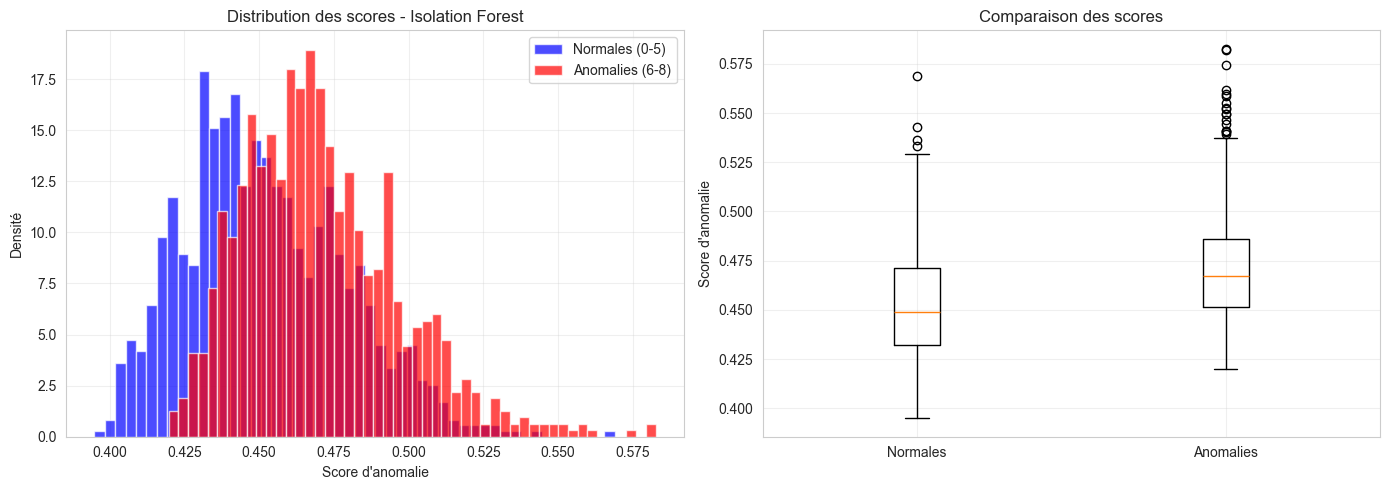

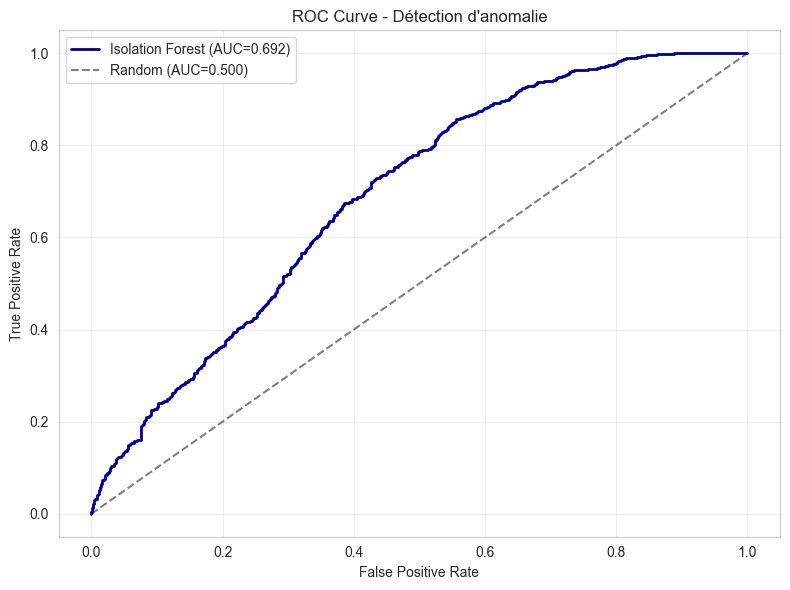


4. SEUIL OPTIMAL
  Seuil: 0.444
  TPR: 0.857
  FPR: 0.555

5. CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.77      0.44      0.56      1028
    Anomalie       0.59      0.86      0.70       972

    accuracy                           0.64      2000
   macro avg       0.68      0.65      0.63      2000
weighted avg       0.68      0.64      0.63      2000



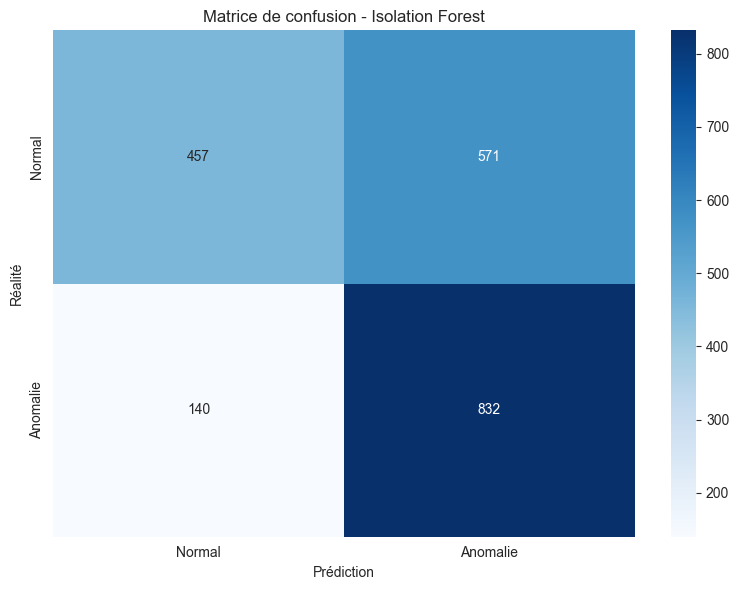

In [ ]:
print("="*80)
print("ISOLATION FOREST - DÉTECTION D'ANOMALIE")
print("="*80)

# 1. Entraînement sur normales uniquement
print("\n1. ENTRAÎNEMENT")
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination='auto',
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_train_features)
print(f"✓ Modèle entraîné sur {len(X_train_features)} échantillons normaux")

# 2. Scores d'anomalie
print("\n2. CALCUL DES SCORES")
# score_samples retourne des valeurs négatives pour les anomalies
anomaly_scores = -iso_forest.score_samples(X_test_features)

# 3. Analyse
normal_mask = y_test_labels < 6
anomaly_mask = y_test_labels >= 6

print(f"\nScore anomalie moyen:")
print(f"  Normales (0-5):  {anomaly_scores[normal_mask].mean():.3f} ± {anomaly_scores[normal_mask].std():.3f}")
print(f"  Anomalies (6-8): {anomaly_scores[anomaly_mask].mean():.3f} ± {anomaly_scores[anomaly_mask].std():.3f}")

# 4. AUROC
y_test_binary = (y_test_labels >= 6).astype(int)
roc_auc = roc_auc_score(y_test_binary, anomaly_scores)
print(f"\n3. PERFORMANCE")
print(f"  AUROC: {roc_auc:.4f}")

# 5. Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution des scores
ax1 = axes[0]
ax1.hist(anomaly_scores[normal_mask], bins=50, alpha=0.7, label='Normales (0-5)', color='blue', density=True)
ax1.hist(anomaly_scores[anomaly_mask], bins=50, alpha=0.7, label='Anomalies (6-8)', color='red', density=True)
ax1.set_xlabel('Score d\'anomalie')
ax1.set_ylabel('Densité')
ax1.set_title('Distribution des scores - Isolation Forest')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Boxplot
ax2 = axes[1]
ax2.boxplot([anomaly_scores[normal_mask], anomaly_scores[anomaly_mask]], 
            labels=['Normales', 'Anomalies'])
ax2.set_ylabel('Score d\'anomalie')
ax2.set_title('Comparaison des scores')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test_binary, anomaly_scores)
plt.plot(fpr, tpr, label=f'Isolation Forest (AUC={roc_auc:.3f})', linewidth=2, color='darkblue')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Détection d\'anomalie')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Trouver seuil optimal
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\n4. SEUIL OPTIMAL")
print(f"  Seuil: {optimal_threshold:.3f}")
print(f"  TPR: {tpr[optimal_idx]:.3f}")
print(f"  FPR: {fpr[optimal_idx]:.3f}")

# Prédictions avec seuil optimal
y_pred_binary = (anomaly_scores > optimal_threshold).astype(int)

print("\n5. CLASSIFICATION REPORT")
print(classification_report(y_test_binary, y_pred_binary, 
                           target_names=['Normal', 'Anomalie']))

# Confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomalie'],
            yticklabels=['Normal', 'Anomalie'])
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion - Isolation Forest')
plt.tight_layout()
plt.show()



### Approches par deep learning

In [35]:
class MyDataset(Dataset):
    def __init__(self, new_labels, signals):
        self.new_labels = torch.tensor(new_labels, dtype=torch.long)
        self.signals = torch.tensor(signals, dtype=torch.float32)

    def __len__(self):
        return len(self.new_labels)

    def __getitem__(self, i):
        signal_tc = self.signals[i]
        # On passe de [T, C] à [C, T] :
        signal_ct = signal_tc.permute(1, 0)
        label = self.new_labels[i]

        return signal_ct, label

In [36]:
dataset_train = MyDataset(new_labels_train, signals_train)
dataloader_train = DataLoader(dataset_train,
                        batch_size=50,
                        shuffle=True
                       )

dataset_valid = MyDataset(new_labels_valid, signals_valid)
dataloader_valid = DataLoader(dataset_valid,
                        batch_size=50,
                        shuffle=False
                       )

dataset_test = MyDataset(new_labels_test, signals_test)
dataloader_test = DataLoader(dataset_test,
                             batch_size=50,
                             shuffle=False)

### Autoencodeur sur l'amplitude des signaux

La première méthode consiste en un autoencodeur (encodeur => espace latent => decodeur) constitué de couches de convolution, chargé de reconstruire les signaux. Lors de la phase de test, si l'erreur de reconstruction (MSE) est trop élevée, le signal est classé comme anomalie.

In [37]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [38]:
# Architecture CNN 1D Simple (1 Canal)

class Amplitude_AE(nn.Module):
    def __init__(self):
        super(Amplitude_AE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # Input: (B, 1, 2048)
            nn.Conv1d(1, 32, kernel_size=7, stride=2, padding=3), # -> 1024
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2), # -> 512
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),

            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1), # -> 256
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),

            nn.Conv1d(128, 64, kernel_size=3, stride=2, padding=1), # -> 128 (Bottleneck)
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),

            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),

            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.ConvTranspose1d(32, 1, kernel_size=7, stride=2, padding=3, output_padding=1),
            # Pas d'activation finale
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model = Amplitude_AE().to(device)

In [39]:
print(f"L\'autoencodeur possède {count_n_param(model)} paramètres.")

L'autoencodeur possède 120769 paramètres.


Les données sont prétraitées afin de gagner en performance. Ainsi on va considérer l'amplitude des signaux plutôt que les signaux bruts. De plus, nous normalisons chaque signal.

In [51]:
# Préparation des Données
BATCH_SIZE = 32

# Fonction de pré-traitement "Module + Instance Norm"

def preprocess_signals(signals):
    # Calcul du Module (Amplitude) : sqrt(I^2 + Q^2)
    # Input shape: (N, 2048, 2) -> Output shape: (N, 2048)
    amplitude = np.sqrt(np.sum(signals**2, axis=2))

    # Normalisation par Instance (Instance Normalization)
    # Pour chaque signal individuellement : (x - mean) / std
    # Cela met tout le monde à la même échelle d'énergie.
    means = np.mean(amplitude, axis=1, keepdims=True)
    stds = np.std(amplitude, axis=1, keepdims=True)

    normalized = (amplitude - means) / (stds + 1e-8)

    return normalized[:, np.newaxis, :]


X_train_processed = preprocess_signals(signals_train)
X_valid_processed = preprocess_signals(signals_valid)
X_test_processed  = preprocess_signals(signals_test)

tensor_x_train = torch.Tensor(X_train_processed).float()
tensor_x_valid = torch.Tensor(X_valid_processed).float()
tensor_x_test  = torch.Tensor(X_test_processed).float()

train_loader = DataLoader(TensorDataset(tensor_x_train, tensor_x_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TensorDataset(tensor_x_valid, tensor_x_valid), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(tensor_x_test), batch_size=BATCH_SIZE, shuffle=False)

In [41]:
LR = 1e-3
EPOCHS = 40

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


print("Training...")
for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validation ---
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data, _ in valid_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            valid_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_valid_loss = valid_loss / len(valid_loader)

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.6f} | Valid Loss: {avg_valid_loss:.6f}")

Training...
Epoch [5/40] Train Loss: 0.004108 | Valid Loss: 0.003633
Epoch [10/40] Train Loss: 0.002477 | Valid Loss: 0.001939
Epoch [15/40] Train Loss: 0.001966 | Valid Loss: 0.001664
Epoch [20/40] Train Loss: 0.001678 | Valid Loss: 0.000990
Epoch [25/40] Train Loss: 0.001596 | Valid Loss: 0.000983
Epoch [30/40] Train Loss: 0.001431 | Valid Loss: 0.001104
Epoch [35/40] Train Loss: 0.001302 | Valid Loss: 0.001709
Epoch [40/40] Train Loss: 0.001186 | Valid Loss: 0.000997


In [42]:
# Évaluation
model.eval()
test_errors = []

# Vraies étiquettes (0=Normal, 1=Anomalie)
y_test_true = np.array([1 if l in [6, 7, 8] else 0 for l in labels_id_test])

with torch.no_grad():
    for data in test_loader:
        data = data[0].to(device)
        reconstruction = model(data)
        # Erreur MSE par signal
        error = torch.mean((data - reconstruction) ** 2, dim=[1, 2])
        test_errors.extend(error.cpu().numpy())

anomaly_scores = np.array(test_errors)

In [43]:
print(f"y_test_true unique values: {np.unique(y_test_true)}")
print(f"y_test_true distribution: {np.bincount(y_test_true)}")
print(f"anomaly_scores min: {anomaly_scores.min()}, max: {anomaly_scores.max()}")

y_test_true unique values: [0 1]
y_test_true distribution: [1028  972]
anomaly_scores min: 0.0007885104278102517, max: 0.0011845503468066454


--- Analyse du Seuil Optimal ---
Meilleur seuil trouvé : 0.000978
J-Score max (TPR - FPR) : 0.3814

Matrice de Confusion au seuil optimal :


<Figure size 600x600 with 0 Axes>

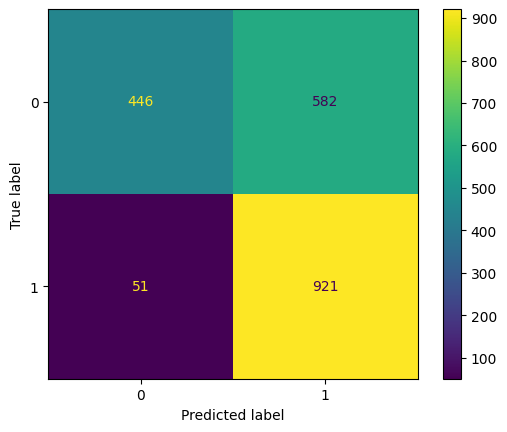

TP (Anomalies détectées) : 921
FP (Fausses alarmes)     : 582


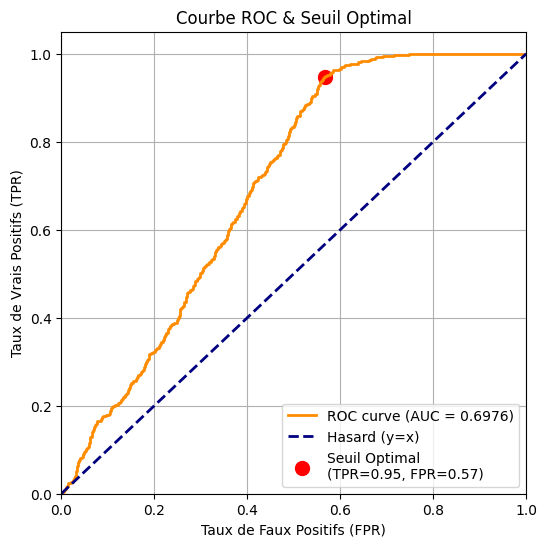

In [44]:
def analyze_and_plot_roc(y_true, y_scores):
    # Calcul des points de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Calcul du meilleur seuil (Indice de Youden : J = TPR - FPR)
    # On cherche le point de la courbe le plus éloigné de la diagonale (hasard)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"--- Analyse du Seuil Optimal ---")
    print(f"Meilleur seuil trouvé : {optimal_threshold:.6f}")
    print(f"J-Score max (TPR - FPR) : {j_scores[optimal_idx]:.4f}")

    # Matrice de confusion avec ce seuil
    y_pred_optimal = (y_scores >= optimal_threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred_optimal)

    print(f"\nMatrice de Confusion au seuil optimal :")
    disp = ConfusionMatrixDisplay(conf_matrix)
    plt.figure(figsize=(6, 6))
    disp.plot()
    plt.show()
    print(f"TP (Anomalies détectées) : {conf_matrix[1,1]}")
    print(f"FP (Fausses alarmes)     : {conf_matrix[0,1]}")

    # Tracé de la courbe
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard (y=x)')

    # Affichage du point optimal
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100,
                label=f'Seuil Optimal\n(TPR={tpr[optimal_idx]:.2f}, FPR={fpr[optimal_idx]:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)')
    plt.ylabel('Taux de Vrais Positifs (TPR)')
    plt.title('Courbe ROC & Seuil Optimal')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return optimal_threshold

best_threshold = analyze_and_plot_roc(y_test_true, anomaly_scores)

#### Résultats :

On observe des performances mitigées : beaucoup de faux positifs (mais peu de vrais négatifs, amnenant à un $FPR = \frac{FP}{FP+TN}$ relativement élevé) mais peu de faux négatifs (ce qui augmente le $Recall =\frac{TP}{TP+FN}$). Néanmoins, un AUC de 0.6976 reste convenable.  

### Essai sans les signaux avec 0dB de SNR :        

Car il n'y a pas de signaux avec un tel bruit dans l'ensemble de test.

In [45]:
mask = snr_train != 0
signals_train = signals_train[mask]
snr_train = snr_train[mask]
labels_id_train = labels_id_train[mask]

mask = snr_valid != 0
signals_valid = signals_valid[mask]
snr_valid = snr_valid[mask]
labels_id_valid = labels_id_valid[mask]

In [46]:
BATCH_SIZE = 32

X_train_processed = preprocess_signals(signals_train)
X_valid_processed = preprocess_signals(signals_valid)
X_test_processed  = preprocess_signals(signals_test)

tensor_x_train = torch.Tensor(X_train_processed).float()
tensor_x_valid = torch.Tensor(X_valid_processed).float()
tensor_x_test  = torch.Tensor(X_test_processed).float()

train_loader = DataLoader(TensorDataset(tensor_x_train, tensor_x_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TensorDataset(tensor_x_valid, tensor_x_valid), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(tensor_x_test), batch_size=BATCH_SIZE, shuffle=False)

In [47]:
LR = 1e-3
EPOCHS = 40

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


print("Training...")
for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validation ---
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data, _ in valid_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            valid_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_valid_loss = valid_loss / len(valid_loader)

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.6f} | Valid Loss: {avg_valid_loss:.6f}")

Training...
Epoch [5/40] Train Loss: 0.001035 | Valid Loss: 0.001146
Epoch [10/40] Train Loss: 0.000988 | Valid Loss: 0.001359
Epoch [15/40] Train Loss: 0.000955 | Valid Loss: 0.000872
Epoch [20/40] Train Loss: 0.000879 | Valid Loss: 0.000895
Epoch [25/40] Train Loss: 0.000902 | Valid Loss: 0.000625
Epoch [30/40] Train Loss: 0.000842 | Valid Loss: 0.000567
Epoch [35/40] Train Loss: 0.000855 | Valid Loss: 0.000854
Epoch [40/40] Train Loss: 0.000828 | Valid Loss: 0.000536


In [48]:
# Évaluation
model.eval()
test_errors = []

# Vraies étiquettes (0=Normal, 1=Anomalie)
y_test_true = np.array([1 if l in [6, 7, 8] else 0 for l in labels_id_test])

with torch.no_grad():
    for data in test_loader:
        data = data[0].to(device)
        reconstruction = model(data)
        # Erreur MSE par signal
        error = torch.mean((data - reconstruction) ** 2, dim=[1, 2])
        test_errors.extend(error.cpu().numpy())

anomaly_scores = np.array(test_errors)

--- Analyse du Seuil Optimal ---
Meilleur seuil trouvé : 0.000521
J-Score max (TPR - FPR) : 0.2336

Matrice de Confusion au seuil optimal :


<Figure size 600x600 with 0 Axes>

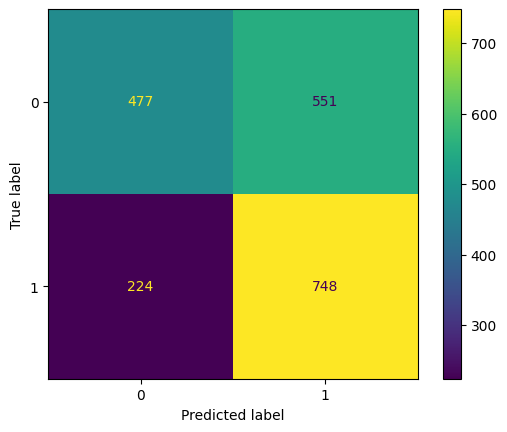

TP (Anomalies détectées) : 748
FP (Fausses alarmes)     : 551


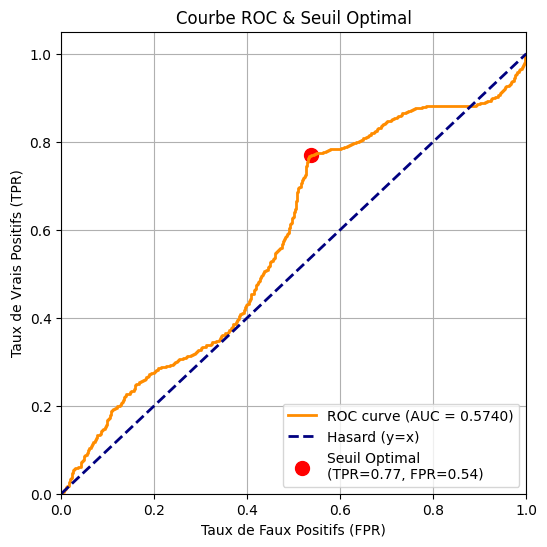

In [49]:
best_threshold = analyze_and_plot_roc(y_test_true, anomaly_scores)

#### Résultats :

On observe que les performances ont diminué avec un AUC de 0.57. Le FPR a diminué et le Recall également. La forme de la courbe AUC ROC laisse cependant penser que les performances sont très instables et que d'autres résultats pourraient être obtenus en réentraînant le modèle.

### Essai entraînant que sur les classes 0,1,2 et en testant que sur 0,1,2,6,7,8 :

Pour montrer que c'est bien les classes 3,4,5 qui ressemblent trop aux anomalies le problème, et pas l'autoencodeur :

In [50]:
mask = (snr_train != 0) & (labels_id_train < 3)
signals_train = signals_train[mask]
snr_train = snr_train[mask]
labels_id_train = labels_id_train[mask]

mask = (snr_valid != 0) & (labels_id_valid < 3)
signals_valid = signals_valid[mask]
snr_valid = snr_valid[mask]
labels_id_valid = labels_id_valid[mask]

mask = (snr_test != 0) & ((labels_id_test < 3) | (labels_id_test > 5))
signals_test = signals_test[mask]
snr_test = snr_test[mask]
labels_id_test = labels_id_test[mask]

In [51]:
BATCH_SIZE = 32

X_train_processed = preprocess_signals(signals_train)
X_valid_processed = preprocess_signals(signals_valid)
X_test_processed  = preprocess_signals(signals_test)

tensor_x_train = torch.Tensor(X_train_processed).float()
tensor_x_valid = torch.Tensor(X_valid_processed).float()
tensor_x_test  = torch.Tensor(X_test_processed).float()

train_loader = DataLoader(TensorDataset(tensor_x_train, tensor_x_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TensorDataset(tensor_x_valid, tensor_x_valid), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(tensor_x_test), batch_size=BATCH_SIZE, shuffle=False)

In [52]:
LR = 1e-3
EPOCHS = 40

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


print("Training...")
for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validation ---
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data, _ in valid_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            valid_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_valid_loss = valid_loss / len(valid_loader)

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.6f} | Valid Loss: {avg_valid_loss:.6f}")

Training...
Epoch [5/40] Train Loss: 0.000814 | Valid Loss: 0.000618
Epoch [10/40] Train Loss: 0.000807 | Valid Loss: 0.000626
Epoch [15/40] Train Loss: 0.000820 | Valid Loss: 0.000653
Epoch [20/40] Train Loss: 0.000769 | Valid Loss: 0.000722
Epoch [25/40] Train Loss: 0.000788 | Valid Loss: 0.000988
Epoch [30/40] Train Loss: 0.000796 | Valid Loss: 0.000582
Epoch [35/40] Train Loss: 0.000781 | Valid Loss: 0.000329
Epoch [40/40] Train Loss: 0.000771 | Valid Loss: 0.000738


In [53]:
# Évaluation
model.eval()
test_errors = []

# Vraies étiquettes (0=Normal, 1=Anomalie)
y_test_true = np.array([1 if l in [6, 7, 8] else 0 for l in labels_id_test])

with torch.no_grad():
    for data in test_loader:
        data = data[0].to(device)
        reconstruction = model(data)
        # Erreur MSE par signal
        error = torch.mean((data - reconstruction) ** 2, dim=[1, 2])
        test_errors.extend(error.cpu().numpy())

anomaly_scores = np.array(test_errors)

--- Analyse du Seuil Optimal ---
Meilleur seuil trouvé : 0.000878
J-Score max (TPR - FPR) : 0.9689

Matrice de Confusion au seuil optimal :


<Figure size 600x600 with 0 Axes>

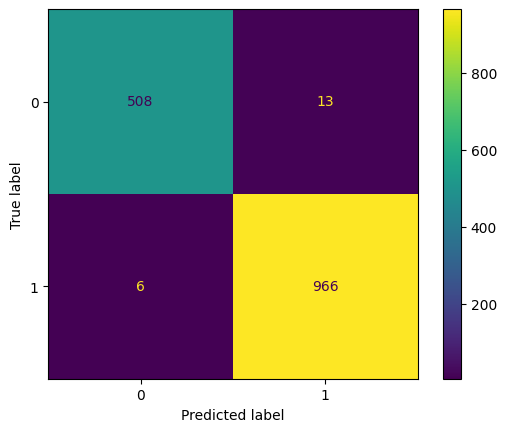

TP (Anomalies détectées) : 966
FP (Fausses alarmes)     : 13


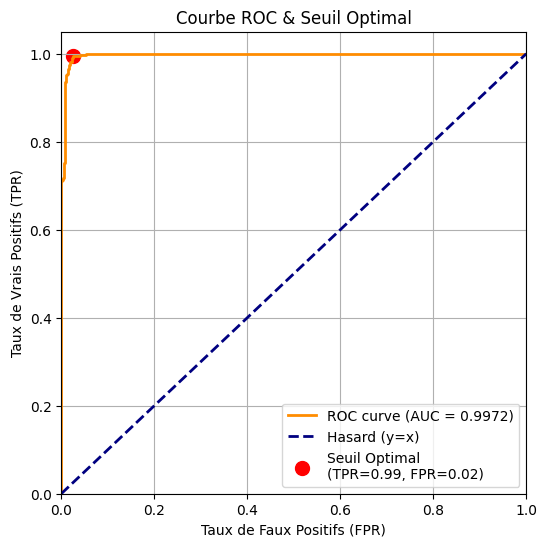

In [54]:
best_threshold = analyze_and_plot_roc(y_test_true, anomaly_scores)

#### Résultats :

On observe des performances quasiment parfaites, on détecte donc très bien les anomalies. On peut donc en déduire que le problème provient des signaux de classes 3, 4 et 5 qui ressemblent beaucoup aux anomalies, et donc l'autoencodeur les confond.

### Et enfin essai uniquement en entraînant sur classes 3,4,5 et en enlevant les classes 0,1,2 du test set pour confirmer :

In [55]:
mask = (snr_train != 0) & (labels_id_train > 2)
signals_train = signals_train[mask]
snr_train = snr_train[mask]
labels_id_train = labels_id_train[mask]

mask = (snr_valid != 0) & (labels_id_valid > 2)
signals_valid = signals_valid[mask]
snr_valid = snr_valid[mask]
labels_id_valid = labels_id_valid[mask]

mask = (snr_test != 0) & (labels_id_test > 2)
signals_test = signals_test[mask]
snr_test = snr_test[mask]
labels_id_test = labels_id_test[mask]

In [ ]:
BATCH_SIZE = 32

X_train_processed = preprocess_signals(signals_train)
X_valid_processed = preprocess_signals(signals_valid)
X_test_processed  = preprocess_signals(signals_test)

tensor_x_train = torch.Tensor(X_train_processed).float()
tensor_x_valid = torch.Tensor(X_valid_processed).float()
tensor_x_test  = torch.Tensor(X_test_processed).float()

train_loader = DataLoader(TensorDataset(tensor_x_train, tensor_x_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TensorDataset(tensor_x_valid, tensor_x_valid), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(tensor_x_test), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
LR = 1e-3
EPOCHS = 40

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


print("Training...")
for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validation ---
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data, _ in valid_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            valid_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_valid_loss = valid_loss / len(valid_loader)

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.6f} | Valid Loss: {avg_valid_loss:.6f}")

Training...
Epoch [5/40] Train Loss: 0.001227 | Valid Loss: 0.001124
Epoch [10/40] Train Loss: 0.001091 | Valid Loss: 0.000502
Epoch [15/40] Train Loss: 0.000975 | Valid Loss: 0.001568
Epoch [20/40] Train Loss: 0.000963 | Valid Loss: 0.000832
Epoch [25/40] Train Loss: 0.000935 | Valid Loss: 0.000673
Epoch [30/40] Train Loss: 0.000900 | Valid Loss: 0.000754
Epoch [35/40] Train Loss: 0.000876 | Valid Loss: 0.000800
Epoch [40/40] Train Loss: 0.000887 | Valid Loss: 0.000914


In [ ]:
# Évaluation
model.eval()
test_errors = []

# Vraies étiquettes (0=Normal, 1=Anomalie)
y_test_true = np.array([1 if l in [6, 7, 8] else 0 for l in labels_id_test])

with torch.no_grad():
    for data in test_loader:
        data = data[0].to(device)
        reconstruction = model(data)
        # Erreur MSE par signal
        error = torch.mean((data - reconstruction) ** 2, dim=[1, 2])
        test_errors.extend(error.cpu().numpy())

anomaly_scores = np.array(test_errors)

--- Analyse du Seuil Optimal ---
Meilleur seuil trouvé : 0.000880
J-Score max (TPR - FPR) : 0.2480

Matrice de Confusion au seuil optimal :


<Figure size 600x600 with 0 Axes>

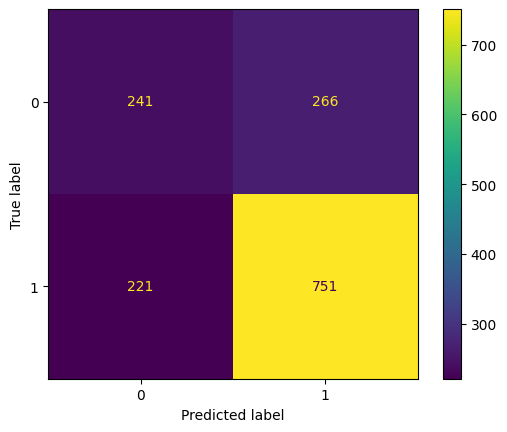

TP (Anomalies détectées) : 751
FP (Fausses alarmes)     : 266


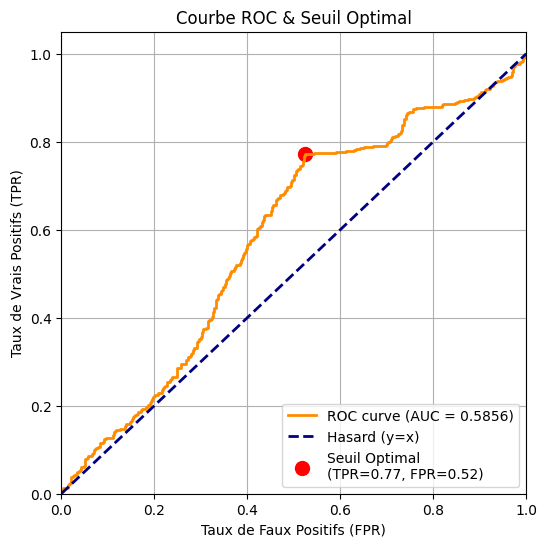

In [ ]:
best_threshold = analyze_and_plot_roc(y_test_true, anomaly_scores)

#### Résultats :

On observe des performances très mitigées, ce qui confirme que c'est bien ces classes qui posent problème lors de la détection, et qu'il va falloir expérimenter une autre approche pour le prendre en compte.

### Méthode 2

Nous allons maintenant utiliser le modèle vu dans le TP 3 qui fonctionnait pour la classification. Nous allons nous appuyer sur la bonne représentation des signaux qu'il a dans son espace latent pour détecter les anomalies.

In [41]:
class SimpleCNN1D(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()

        # Input: [B, 2, 2048]
        self.features = nn.Sequential(
            # Bloc 1
            nn.Conv1d(2, 32, kernel_size=7, padding=3),     # [B, 32, 2048]
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),                                 # [B, 32, 1024]

            # Bloc 2
            nn.Conv1d(32, 64, kernel_size=5, padding=2),    # [B, 64, 1024]
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),                                 # [B, 64, 512]

            # Bloc 3
            nn.Conv1d(64, 128, kernel_size=5, padding=2),   # [B, 128, 512]
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),                                 # [B, 128, 256]

            # Bloc 4
            nn.Conv1d(128, 256, kernel_size=3, padding=1),  # [B, 256, 256]
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)                          # [B, 256, 1]
        )

        # Classificateur
        self.classifier = nn.Sequential(
            nn.Flatten(),                   # [B, 256]
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)       # [B, 6]
        )

    def forward(self, x):
        # x: [B, 2, 2048]
        x = self.features(x)       # [B, 256, 1]
        x = self.classifier(x)     # [B, 6]
        return x

Notre 1er modèle prend en entrée les canaux I et Q: il apprend des motifs dépendant des 2<br>
Pas de tri sur les SNR car on a vu précédemment que cela ne fonctionnait pas.<br>
Nous allons tester 2 instances de normalisations, l'une uniquement par l'énergie du signal, et une autre en rendant les données centrées-réduites (moyenne=0, var=1).


In [ ]:
# On recharge les données pour être sûr d'avoir les bonnes

data_path='E:\\Documents\\MVA\\Traitement signal deep\\Projet\\train.hdf5'
data = h5py.File(data_path , 'r')
signals_train = np.array(data['signaux'])
snr_train =  np.array(data['snr'])
labels_id_train = np.array(data['labels'])
data.close()

data_path='E:\\Documents\\MVA\\Traitement signal deep\\Projet\\test_anomalies.hdf5'
data = h5py.File(data_path , 'r')
signals_test = np.array(data['signaux'])
snr_test =  np.array(data['snr'])
labels_id_test = np.array(data['labels'])
data.close()

data_path='E:\\Documents\\MVA\\Traitement signal deep\\Projet\\validation.hdf5'
data = h5py.File(data_path , 'r')
signals_valid = np.array(data['signaux'])
snr_valid =  np.array(data['snr'])
labels_id_valid = np.array(data['labels'])
data.close()

# Test set - labels binaires pour évaluation de détection d'anomalies
labels_test_binary = np.array([0 if label <= 5 else 1 for label in labels_id_test])

print(f"Train: {len(labels_id_train)} samples - Classes: {np.unique(labels_id_train)}")
print(f"Valid: {len(labels_id_valid)} samples - Classes: {np.unique(labels_id_valid)}")
print(f"Test mixte: {len(labels_id_test)} samples - Normal: {(labels_test_binary==0).sum()}, Anomalies: {(labels_test_binary==1).sum()}")

# PRÉPARATION DES DONNÉES
BATCH_SIZE = 32

# Fonction de normalisation par énergie (garde I et Q séparés)
def preprocess_signals_amplitude(signals):
    """
    Normalisation par l'énergie du signal tout en gardant I/Q séparés
    Input shape: (N, 2048, 2) -> Output shape: (N, 2, 2048)
    """
    # Calcul de l'énergie RMS : sqrt(mean(I^2 + Q^2))
    energy = np.sqrt(np.mean(np.sum(signals**2, axis=2), axis=1))

    # Normalisation : diviser chaque signal par son énergie
    # Reshape energy pour broadcasting: (N, 1, 1)
    energy = energy[:, np.newaxis, np.newaxis]

    normalized = signals / (energy + 1e-8)

    # Transposition pour Conv1D: (N, 2048, 2) -> (N, 2, 2048)
    normalized = normalized.transpose(0, 2, 1)

    return normalized

def preprocess_signals_IQ(signals):
    """
    Centre et réduit chaque signal par canal (I/Q) puis normalise par énergie totale.
    Input shape: (N, 2048, 2) -> Output shape: (N, 2, 2048)
    """
    # Centrage et réduction par canal
    mean_per_channel = np.mean(signals, axis=1, keepdims=True)  # shape: (N,1,2)
    std_per_channel = np.std(signals, axis=1, keepdims=True) + 1e-8  # éviter div0
    standardized = (signals - mean_per_channel) / std_per_channel

    # Normalisation par énergie totale I+Q
    energy = np.sqrt(np.mean(np.sum(standardized**2, axis=2), axis=1))  # shape: (N,)
    energy = energy[:, np.newaxis, np.newaxis]  # broadcasting
    normalized = standardized / (energy + 1e-8)

    # Transposition pour Conv1D: (N, 2048, 2) -> (N, 2, 2048)
    normalized = normalized.transpose(0, 2, 1)

    return normalized




Train: 30000 samples - Classes: [0 1 2 3 4 5]
Valid: 10000 samples - Classes: [0 1 2 3 4 5]
Test mixte: 2000 samples - Normal: 1028, Anomalies: 972


In [ ]:
# Appliquer la normalisation
X_train_processed = preprocess_signals_IQ(signals_train)
X_valid_processed = preprocess_signals_IQ(signals_valid)
X_test_processed  = preprocess_signals_IQ(signals_test)

print(f"\nNormalisation par énergie appliquée (2 canaux I/Q conservés):")
print(f"  Train shape: {X_train_processed.shape}")  # (N, 2, 2048)
print(f"  Valid shape: {X_valid_processed.shape}")
print(f"  Test shape: {X_test_processed.shape}")

# Conversion en tensors
tensor_x_train = torch.Tensor(X_train_processed).float()
tensor_y_train = torch.Tensor(labels_id_train).long()

tensor_x_valid = torch.Tensor(X_valid_processed).float()
tensor_y_valid = torch.Tensor(labels_id_valid).long()

tensor_x_test  = torch.Tensor(X_test_processed).float()
tensor_y_test  = torch.Tensor(labels_id_test).long()

# Créer les DataLoaders
train_loader = DataLoader(TensorDataset(tensor_x_train, tensor_y_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TensorDataset(tensor_x_valid, tensor_y_valid), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(tensor_x_test, tensor_y_test), batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataloaders créés:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Valid batches: {len(valid_loader)}")
print(f"  Test batches: {len(test_loader)}")


Normalisation par énergie appliquée (2 canaux I/Q conservés):
  Train shape: (30000, 2, 2048)
  Valid shape: (10000, 2, 2048)
  Test shape: (2000, 2, 2048)

Dataloaders créés:
  Train batches: 938
  Valid batches: 313
  Test batches: 63


In [43]:
LR = 1e-3
EPOCHS = 100

# Initialiser le modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN1D(n_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Historique des métriques
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Variable pour sauvegarder le meilleur modèle
best_valid_acc = 0.0

print("Training...")
for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for signals, labels in train_loader:
        signals = signals.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # --- Validation ---
    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for signals, labels in valid_loader:
            signals = signals.to(device)
            labels = labels.to(device)

            outputs = model(signals)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    avg_valid_loss = valid_loss / len(valid_loader)
    train_acc = 100 * train_correct / train_total
    valid_acc = 100 * valid_correct / valid_total

    # Sauvegarder l'historique
    train_losses.append(avg_train_loss)
    val_losses.append(avg_valid_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(valid_acc)

    # Sauvegarder le meilleur modèle
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_cnn_model.pth')

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.6f} | Valid Loss: {avg_valid_loss:.6f} | Train Acc: {train_acc:.2f}% | Valid Acc: {valid_acc:.2f}%")

print("\nTraining completed!")
print(f"Best validation accuracy: {best_valid_acc:.2f}%")

Training...
Epoch [5/100] Train Loss: 0.502432 | Valid Loss: 0.883840 | Train Acc: 70.66% | Valid Acc: 65.59%
Epoch [10/100] Train Loss: 0.413658 | Valid Loss: 1.380141 | Train Acc: 77.86% | Valid Acc: 68.84%
Epoch [15/100] Train Loss: 0.295020 | Valid Loss: 1.531611 | Train Acc: 84.39% | Valid Acc: 71.57%
Epoch [20/100] Train Loss: 0.257185 | Valid Loss: 0.862407 | Train Acc: 86.25% | Valid Acc: 77.60%
Epoch [25/100] Train Loss: 0.235124 | Valid Loss: 0.377217 | Train Acc: 87.18% | Valid Acc: 83.25%
Epoch [30/100] Train Loss: 0.215974 | Valid Loss: 0.825492 | Train Acc: 88.29% | Valid Acc: 78.11%
Epoch [35/100] Train Loss: 0.203395 | Valid Loss: 0.362282 | Train Acc: 88.90% | Valid Acc: 84.98%
Epoch [40/100] Train Loss: 0.181301 | Valid Loss: 0.642461 | Train Acc: 90.57% | Valid Acc: 82.89%
Epoch [45/100] Train Loss: 0.163071 | Valid Loss: 0.483757 | Train Acc: 91.88% | Valid Acc: 84.13%
Epoch [50/100] Train Loss: 0.135875 | Valid Loss: 0.864762 | Train Acc: 93.86% | Valid Acc: 84.34%

Le modèle est très bon pour la classification des siganux des classe 0 à 5. Nous pouvons donc supposer que son espace latent offre une représentation riche de signaux qui va nous permettre de les différencier

### Modèles de détections dans l'espace latent

Nous utilisons 3 modèles différents qui vont nous permettre de détecter les anomalies:
- Une isolation forest: le principe est de faire un arbre qui cherche à isoler chaque point. Moins l'arbre a besoin de noeuds, plus l'élément a un score d'anomalie fort
- Un one class svm: il cherche une frontière qui englobe la majorité des points normaux, puis on regarde où sont les points du test par rapport à cette frontière
- Local outlier Factor (LOF): compare la densité locale autour d'un point à celle de ses voisins: si celle des voisins est plus haute en moyenne c'est qu'il est outlier

C:\Users\Mathéo\AppData\Local\Temp\ipykernel_36068\1426264909.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_model.pth'))


Train signals preprocessed shape: (30000, 2, 2048)
Train features shape: (30000, 128)
Test signals preprocessed shape: (2000, 2, 2048)
Test features shape: (2000, 128)

Test set - Normal: 1028, Anomalies: 972

ANOMALY DETECTION - ISOLATION FOREST
AUROC: 0.5941
              precision    recall  f1-score   support

      Normal       0.58      0.59      0.58      1028
    Anomalie       0.56      0.56      0.56       972

    accuracy                           0.57      2000
   macro avg       0.57      0.57      0.57      2000
weighted avg       0.57      0.57      0.57      2000


ANOMALY DETECTION - ONE-CLASS SVM
AUROC: 0.5919
              precision    recall  f1-score   support

      Normal       0.59      0.66      0.62      1028
    Anomalie       0.59      0.51      0.55       972

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.59      0.59      0.59      2000


ANOMALY DETECTION - LOCAL OUTLIER F

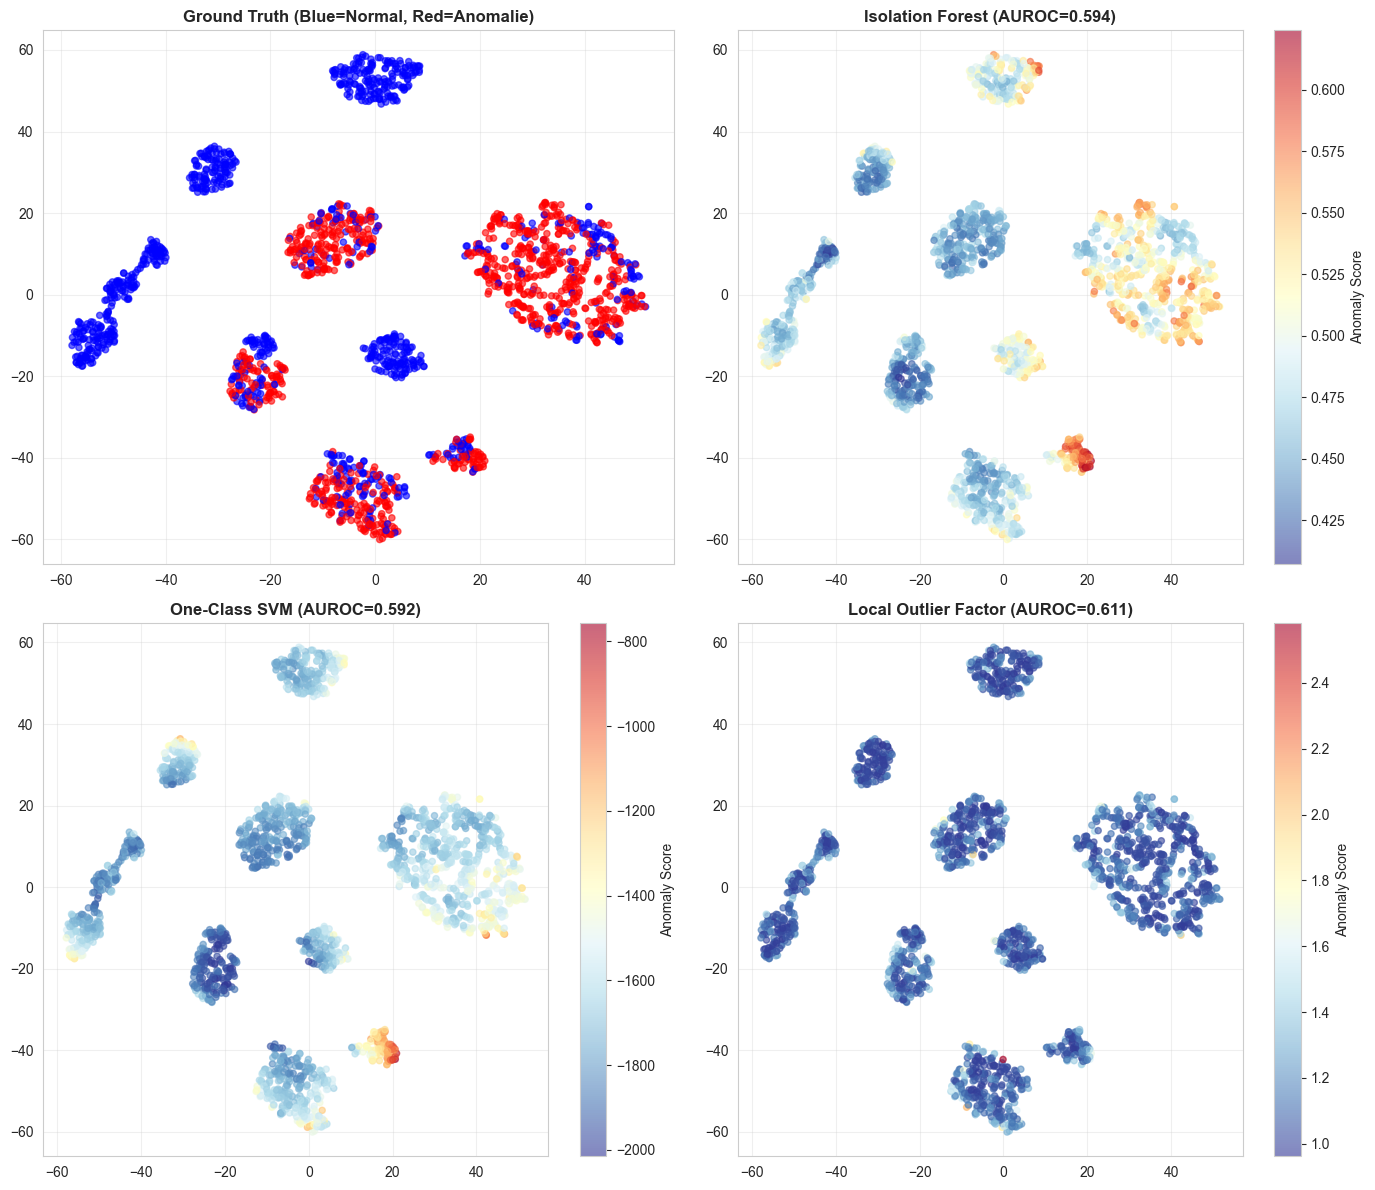

In [62]:
# FEATURE EXTRACTOR

# Charger le modèle entraîné
model = SimpleCNN1D(n_classes=6).to(device)
model.load_state_dict(torch.load('best_cnn_model.pth'))
model.eval()

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = model.features
        self.flatten = nn.Flatten()
        self.fc1 = model.classifier[1]  # Linear(256, 128)
        self.relu = model.classifier[2]  # ReLU

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        return x  # Retourne features 128-dim

feature_extractor = FeatureExtractor(model).to(device)
feature_extractor.eval()

# EXTRACTION FEATURES TRAIN SET

#X_train_processed = preprocess_signals_amplitude(signals_train)  
X_train_processed = preprocess_signals_IQ(signals_train)  
print(f"Train signals preprocessed shape: {X_train_processed.shape}")

train_features = []
batch_size = 64
with torch.no_grad():
    for i in range(0, len(X_train_processed), batch_size):
        batch = torch.FloatTensor(X_train_processed[i:i+batch_size]).to(device)
        features = feature_extractor(batch)
        train_features.append(features.cpu().numpy())

train_features = np.vstack(train_features)
print(f"Train features shape: {train_features.shape}")

# EXTRACTION FEATURES TEST SET

#X_test_processed = preprocess_signals_amplitude(signals_test)  
X_test_processed = preprocess_signals_IQ(signals_test)  
print(f"Test signals preprocessed shape: {X_test_processed.shape}")

test_features = []
with torch.no_grad():
    for i in range(0, len(X_test_processed), batch_size):
        batch = torch.FloatTensor(X_test_processed[i:i+batch_size]).to(device)
        features = feature_extractor(batch)
        test_features.append(features.cpu().numpy())

test_features = np.vstack(test_features)
print(f"Test features shape: {test_features.shape}")

# Ground truth
y_true = (labels_id_test > 5).astype(int)  # Utiliser labels_id_test (déjà chargé)
print(f"\nTest set - Normal: {(y_true==0).sum()}, Anomalies: {(y_true==1).sum()}")

# ANOMALY DETECTION

print("\n" + "="*60)
print("ANOMALY DETECTION - ISOLATION FOREST")
print("="*60)
iso_forest = IsolationForest(contamination=0.3, random_state=42)
iso_forest.fit(train_features)
y_pred_if = (iso_forest.predict(test_features) == -1).astype(int)
scores_if = -iso_forest.score_samples(test_features)
auc_if = roc_auc_score(y_true, scores_if)
print(f"AUROC: {auc_if:.4f}")
print(classification_report(y_true, y_pred_if, target_names=['Normal', 'Anomalie']))

print("\n" + "="*60)
print("ANOMALY DETECTION - ONE-CLASS SVM")
print("="*60)
oc_svm = OneClassSVM(nu=0.3, kernel='rbf', gamma='auto')
oc_svm.fit(train_features)
y_pred_svm = (oc_svm.predict(test_features) == -1).astype(int)
scores_svm = -oc_svm.score_samples(test_features)
auc_svm = roc_auc_score(y_true, scores_svm)
print(f"AUROC: {auc_svm:.4f}")
print(classification_report(y_true, y_pred_svm, target_names=['Normal', 'Anomalie']))

print("\n" + "="*60)
print("ANOMALY DETECTION - LOCAL OUTLIER FACTOR")
print("="*60)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.3, novelty=True)
lof.fit(train_features)
y_pred_lof = (lof.predict(test_features) == -1).astype(int)
scores_lof = -lof.score_samples(test_features)
auc_lof = roc_auc_score(y_true, scores_lof)
print(f"AUROC: {auc_lof:.4f}")
print(classification_report(y_true, y_pred_lof, target_names=['Normal', 'Anomalie']))

# VISUALISATION T-SNE

print("\nCalcul du t-SNE pour visualisation...")
tsne = TSNE(n_components=2, random_state=42)
test_features_2d = tsne.fit_transform(test_features)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Ground truth
ax = axes[0, 0]
colors = ['blue' if l <= 5 else 'red' for l in labels_id_test]
ax.scatter(test_features_2d[:, 0], test_features_2d[:, 1], c=colors, alpha=0.6, s=20)
ax.set_title('Ground Truth (Blue=Normal, Red=Anomalie)', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Isolation Forest
ax = axes[0, 1]
scatter = ax.scatter(test_features_2d[:, 0], test_features_2d[:, 1],
                     c=scores_if, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'Isolation Forest (AUROC={auc_if:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: One-Class SVM
ax = axes[1, 0]
scatter = ax.scatter(test_features_2d[:, 0], test_features_2d[:, 1],
                     c=scores_svm, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'One-Class SVM (AUROC={auc_svm:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: LOF
ax = axes[1, 1]
scatter = ax.scatter(test_features_2d[:, 0], test_features_2d[:, 1],
                     c=scores_lof, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'Local Outlier Factor (AUROC={auc_lof:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

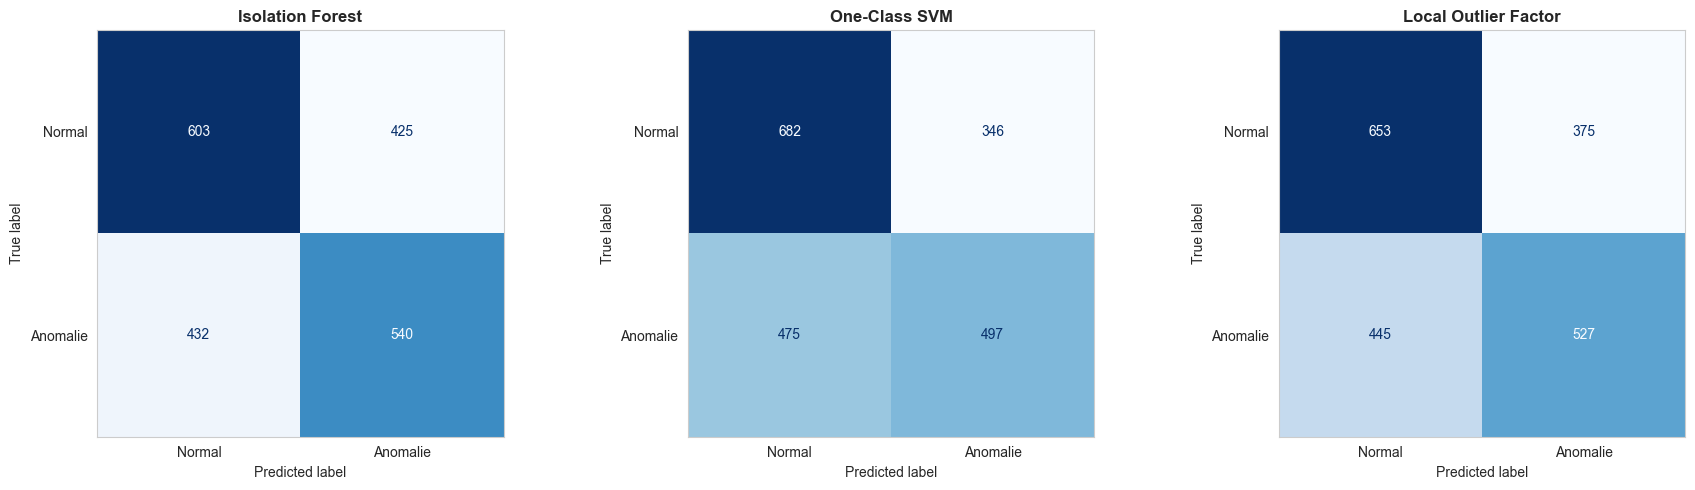

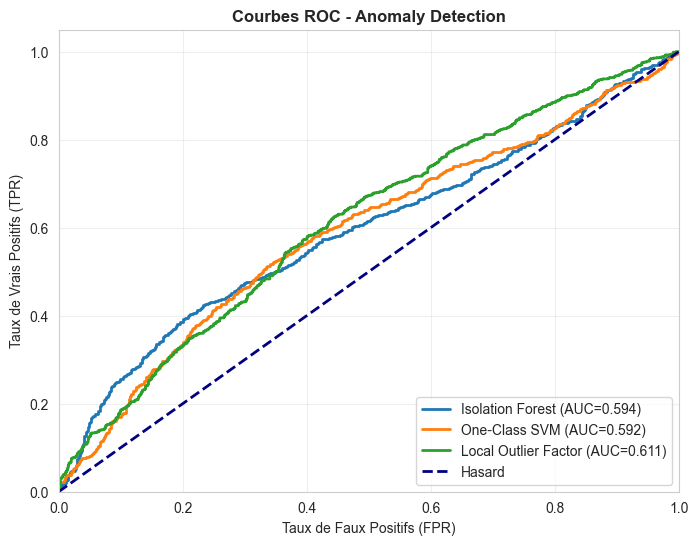


--- Métriques harmonisées ---
Isolation Forest     -> Précision: 0.560, Recall: 0.556, F1-score: 0.558
One-Class SVM        -> Précision: 0.590, Recall: 0.511, F1-score: 0.548
Local Outlier Factor -> Précision: 0.584, Recall: 0.542, F1-score: 0.562


In [63]:

# Liste des modèles / scores
models = {
    "Isolation Forest": (y_pred_if, scores_if),
    "One-Class SVM": (y_pred_svm, scores_svm),
    "Local Outlier Factor": (y_pred_lof, scores_lof)
}

# -----------------------------
# Matrices de confusion
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, (y_pred, _)) in enumerate(models.items()):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal','Anomalie'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name, fontweight='bold')
    axes[i].grid(False)

plt.tight_layout()
plt.show()

# -----------------------------
# Courbes ROC
# -----------------------------
plt.figure(figsize=(8, 6))
for name, (_, y_score) in models.items():
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_val = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc_val:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC - Anomaly Detection', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# -----------------------------
# Précision, Recall, F1-score harmonisés
# -----------------------------
print("\n--- Métriques harmonisées ---")
for name, (y_pred, _) in models.items():
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{name:<20} -> Précision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")


### Determination du problème dans la classification

Comme vu avec l'autoencoder, nous allons regarder quelles classes posent problème. Nous allons encore une fois séparé le problème entre les groupes de classe [0-2] et [3-5]
Nous allons entrainer des modèles à distinguer pour chaque sous groupe, ce sous groupe des anomalies.
Nous prenons alors dans chacun des modèles le sous groupe pertinent pour entrainer le modèle de détection d'outlier, puis nous le testons sur le test set filtré sur le sous groupe correspondant et les anomalies

Train - Classes 0-2 uniquement: 15164 samples
Test - Classes 0-2 + anomalies: 1493 samples
Train features: (15164, 128), Test features: (1493, 128)
Test - Normal (0-2): 521, Anomalies (6-8): 972

ISOLATION FOREST - Classes 0-2
AUROC: 0.9998
                precision    recall  f1-score   support

  Normal (0-2)       1.00      0.62      0.77       521
Anomalie (6-8)       0.83      1.00      0.91       972

      accuracy                           0.87      1493
     macro avg       0.92      0.81      0.84      1493
  weighted avg       0.89      0.87      0.86      1493


ONE-CLASS SVM - Classes 0-2
AUROC: 1.0000
                precision    recall  f1-score   support

  Normal (0-2)       1.00      0.71      0.83       521
Anomalie (6-8)       0.86      1.00      0.93       972

      accuracy                           0.90      1493
     macro avg       0.93      0.85      0.88      1493
  weighted avg       0.91      0.90      0.89      1493


LOCAL OUTLIER FACTOR - Classes 0-2
AU

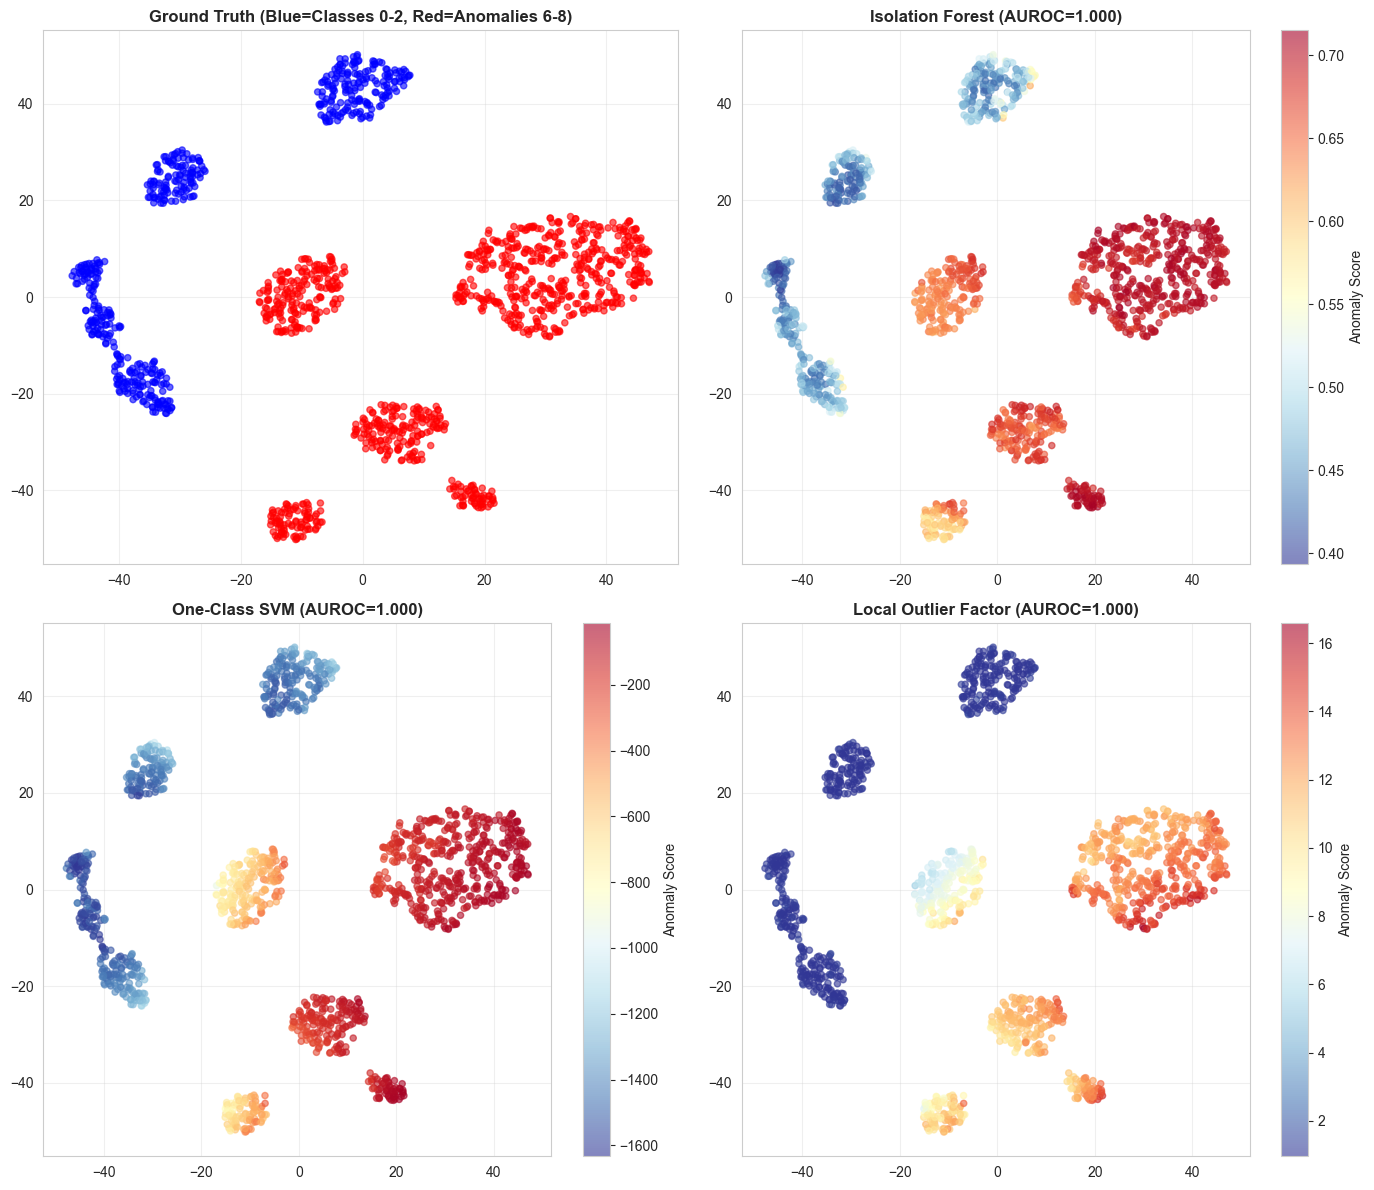

In [ ]:
# EXPÉRIENCE : ENTRAÎNEMENT SUR CLASSES 0-2 UNIQUEMENT 

# Filtrer uniquement classes 0-2 pour le train
mask_train_02 = np.isin(labels_id_train, [0, 1, 2])
signals_train_02 = signals_train[mask_train_02]
labels_train_02 = labels_id_train[mask_train_02]

# Filtrer test : garder classes 0-2 ET 6-8 (exclure 3-5)
mask_test_02 = np.isin(labels_id_test, [0, 1, 2, 6, 7, 8])
signals_test_02 = signals_test[mask_test_02]
labels_test_02 = labels_id_test[mask_test_02]

print(f"Train - Classes 0-2 uniquement: {len(labels_train_02)} samples")
print(f"Test - Classes 0-2 + anomalies: {len(labels_test_02)} samples")

# Preprocessing
X_train_processed_02 = preprocess_signals_IQ(signals_train_02)
X_test_processed_02 = preprocess_signals_IQ(signals_test_02)

# Extraction features
train_features_02 = []
test_features_02 = []
batch_size = 64

with torch.no_grad():
    for i in range(0, len(X_train_processed_02), batch_size):
        batch = torch.FloatTensor(X_train_processed_02[i:i+batch_size]).to(device)
        features = feature_extractor(batch)
        train_features_02.append(features.cpu().numpy())

    for i in range(0, len(X_test_processed_02), batch_size):
        batch = torch.FloatTensor(X_test_processed_02[i:i+batch_size]).to(device)
        features = feature_extractor(batch)
        test_features_02.append(features.cpu().numpy())

train_features_02 = np.vstack(train_features_02)
test_features_02 = np.vstack(test_features_02)
print(f"Train features: {train_features_02.shape}, Test features: {test_features_02.shape}")

# Ground truth
y_true_02 = (labels_test_02 > 5).astype(int)
print(f"Test - Normal (0-2): {(y_true_02==0).sum()}, Anomalies (6-8): {(y_true_02==1).sum()}")

# ANOMALY DETECTION

print("\n" + "="*60)
print("ISOLATION FOREST - Classes 0-2")
print("="*60)
iso_forest_02 = IsolationForest(contamination=0.3, random_state=42)
iso_forest_02.fit(train_features_02)
y_pred_if_02 = (iso_forest_02.predict(test_features_02) == -1).astype(int)
scores_if_02 = -iso_forest_02.score_samples(test_features_02)
auc_if_02 = roc_auc_score(y_true_02, scores_if_02)
print(f"AUROC: {auc_if_02:.4f}")
print(classification_report(y_true_02, y_pred_if_02, target_names=['Normal (0-2)', 'Anomalie (6-8)']))

print("\n" + "="*60)
print("ONE-CLASS SVM - Classes 0-2")
print("="*60)
oc_svm_02 = OneClassSVM(nu=0.3, kernel='rbf', gamma='auto')
oc_svm_02.fit(train_features_02)
y_pred_svm_02 = (oc_svm_02.predict(test_features_02) == -1).astype(int)
scores_svm_02 = -oc_svm_02.score_samples(test_features_02)
auc_svm_02 = roc_auc_score(y_true_02, scores_svm_02)
print(f"AUROC: {auc_svm_02:.4f}")
print(classification_report(y_true_02, y_pred_svm_02, target_names=['Normal (0-2)', 'Anomalie (6-8)']))

print("\n" + "="*60)
print("LOCAL OUTLIER FACTOR - Classes 0-2")
print("="*60)
lof_02 = LocalOutlierFactor(n_neighbors=20, contamination=0.3, novelty=True)
lof_02.fit(train_features_02)
y_pred_lof_02 = (lof_02.predict(test_features_02) == -1).astype(int)
scores_lof_02 = -lof_02.score_samples(test_features_02)
auc_lof_02 = roc_auc_score(y_true_02, scores_lof_02)
print(f"AUROC: {auc_lof_02:.4f}")
print(classification_report(y_true_02, y_pred_lof_02, target_names=['Normal (0-2)', 'Anomalie (6-8)']))

# VISUALISATION T-SNE

print("\nCalcul du t-SNE pour visualisation...")
tsne_02 = TSNE(n_components=2, random_state=42)
test_features_2d_02 = tsne_02.fit_transform(test_features_02)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Ground truth
ax = axes[0, 0]
colors = ['blue' if l <= 2 else 'red' for l in labels_test_02]
ax.scatter(test_features_2d_02[:, 0], test_features_2d_02[:, 1], c=colors, alpha=0.6, s=20)
ax.set_title('Ground Truth (Blue=Classes 0-2, Red=Anomalies 6-8)', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Isolation Forest
ax = axes[0, 1]
scatter = ax.scatter(test_features_2d_02[:, 0], test_features_2d_02[:, 1],
                     c=scores_if_02, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'Isolation Forest (AUROC={auc_if_02:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: One-Class SVM
ax = axes[1, 0]
scatter = ax.scatter(test_features_2d_02[:, 0], test_features_2d_02[:, 1],
                     c=scores_svm_02, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'One-Class SVM (AUROC={auc_svm_02:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: LOF
ax = axes[1, 1]
scatter = ax.scatter(test_features_2d_02[:, 0], test_features_2d_02[:, 1],
                     c=scores_lof_02, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'Local Outlier Factor (AUROC={auc_lof_02:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

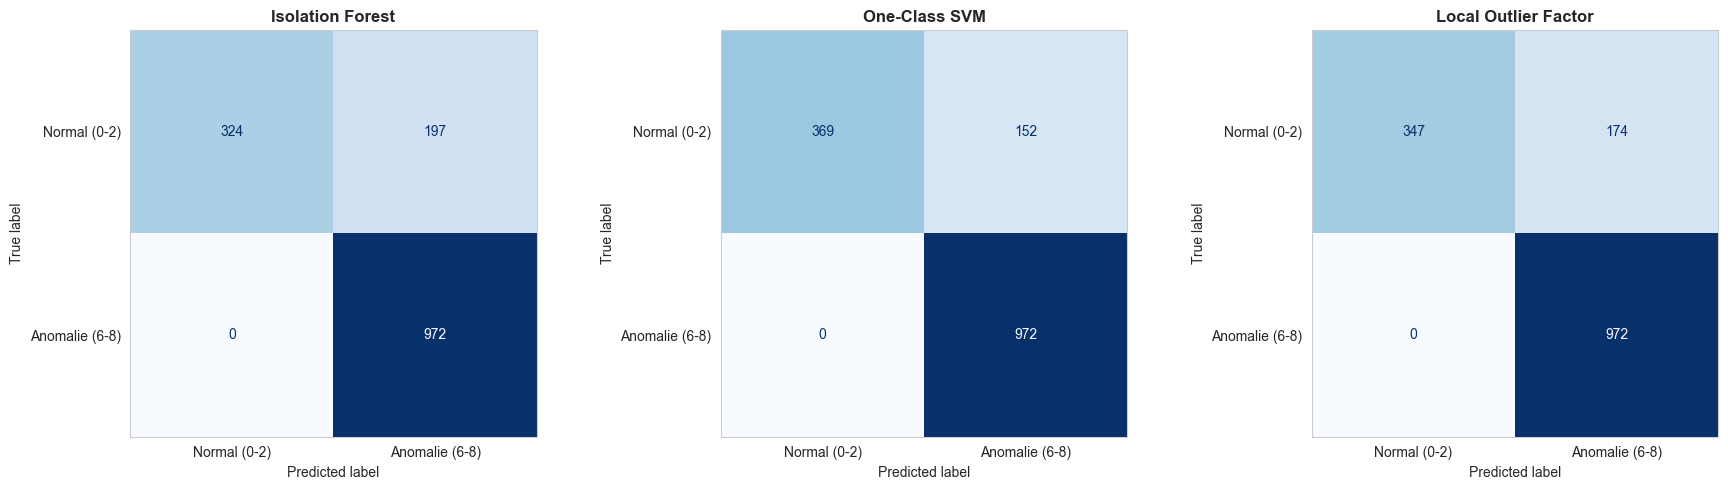

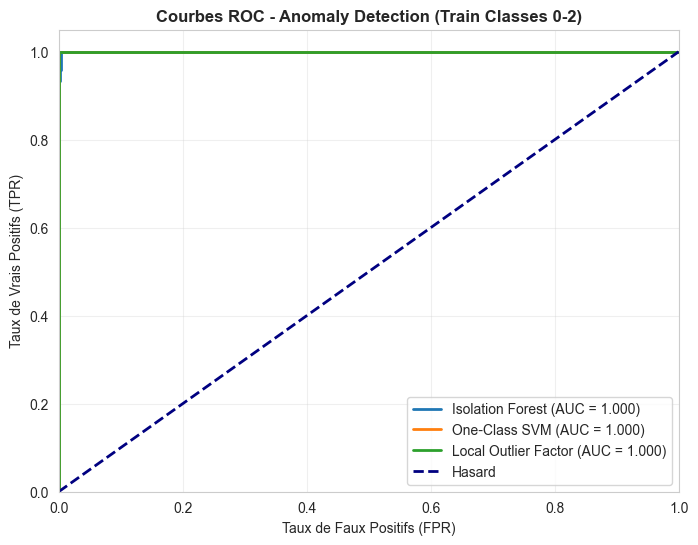

Isolation Forest -> Précision: 0.831, Recall: 1.000, F1-score: 0.908
One-Class SVM -> Précision: 0.865, Recall: 1.000, F1-score: 0.927
Local Outlier Factor -> Précision: 0.848, Recall: 1.000, F1-score: 0.918


In [ ]:


# Modèles et scores
models_02 = {
    "Isolation Forest": (y_pred_if_02, scores_if_02),
    "One-Class SVM": (y_pred_svm_02, scores_svm_02),
    "Local Outlier Factor": (y_pred_lof_02, scores_lof_02)
}

# MATRICES DE CONFUSION côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, (y_pred, _)) in enumerate(models_02.items()):
    cm = confusion_matrix(y_true_02, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal (0-2)','Anomalie (6-8)'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name, fontweight='bold')
    axes[i].grid(False)
plt.tight_layout()
plt.show()

# COURBES ROC
plt.figure(figsize=(8, 6))
for name, (_, y_score) in models_02.items():
    fpr, tpr, _ = roc_curve(y_true_02, y_score)
    auc_val = roc_auc_score(y_true_02, y_score)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_val:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC - Anomaly Detection (Train Classes 0-2)', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# MÉTRIQUES PRÉCISION / RECALL / F1
for name, (y_pred, _) in models_02.items():
    precision = precision_score(y_true_02, y_pred)
    recall = recall_score(y_true_02, y_pred)
    f1 = f1_score(y_true_02, y_pred)
    print(f"{name} -> Précision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")


Train - Classes 3-5 uniquement: 14836 samples
Test - Classes 3-5 + anomalies: 1479 samples
Train features: (14836, 128), Test features: (1479, 128)
Test - Normal (3-5): 507, Anomalies (6-8): 972

ISOLATION FOREST - Classes 3-5
AUROC: 0.6549
                precision    recall  f1-score   support

  Normal (3-5)       0.46      0.57      0.51       507
Anomalie (6-8)       0.74      0.64      0.69       972

      accuracy                           0.62      1479
     macro avg       0.60      0.61      0.60      1479
  weighted avg       0.64      0.62      0.63      1479


ONE-CLASS SVM - Classes 3-5
AUROC: 0.5930
                precision    recall  f1-score   support

  Normal (3-5)       0.40      0.65      0.50       507
Anomalie (6-8)       0.73      0.49      0.59       972

      accuracy                           0.55      1479
     macro avg       0.57      0.57      0.54      1479
  weighted avg       0.62      0.55      0.56      1479


LOCAL OUTLIER FACTOR - Classes 3-5
AU

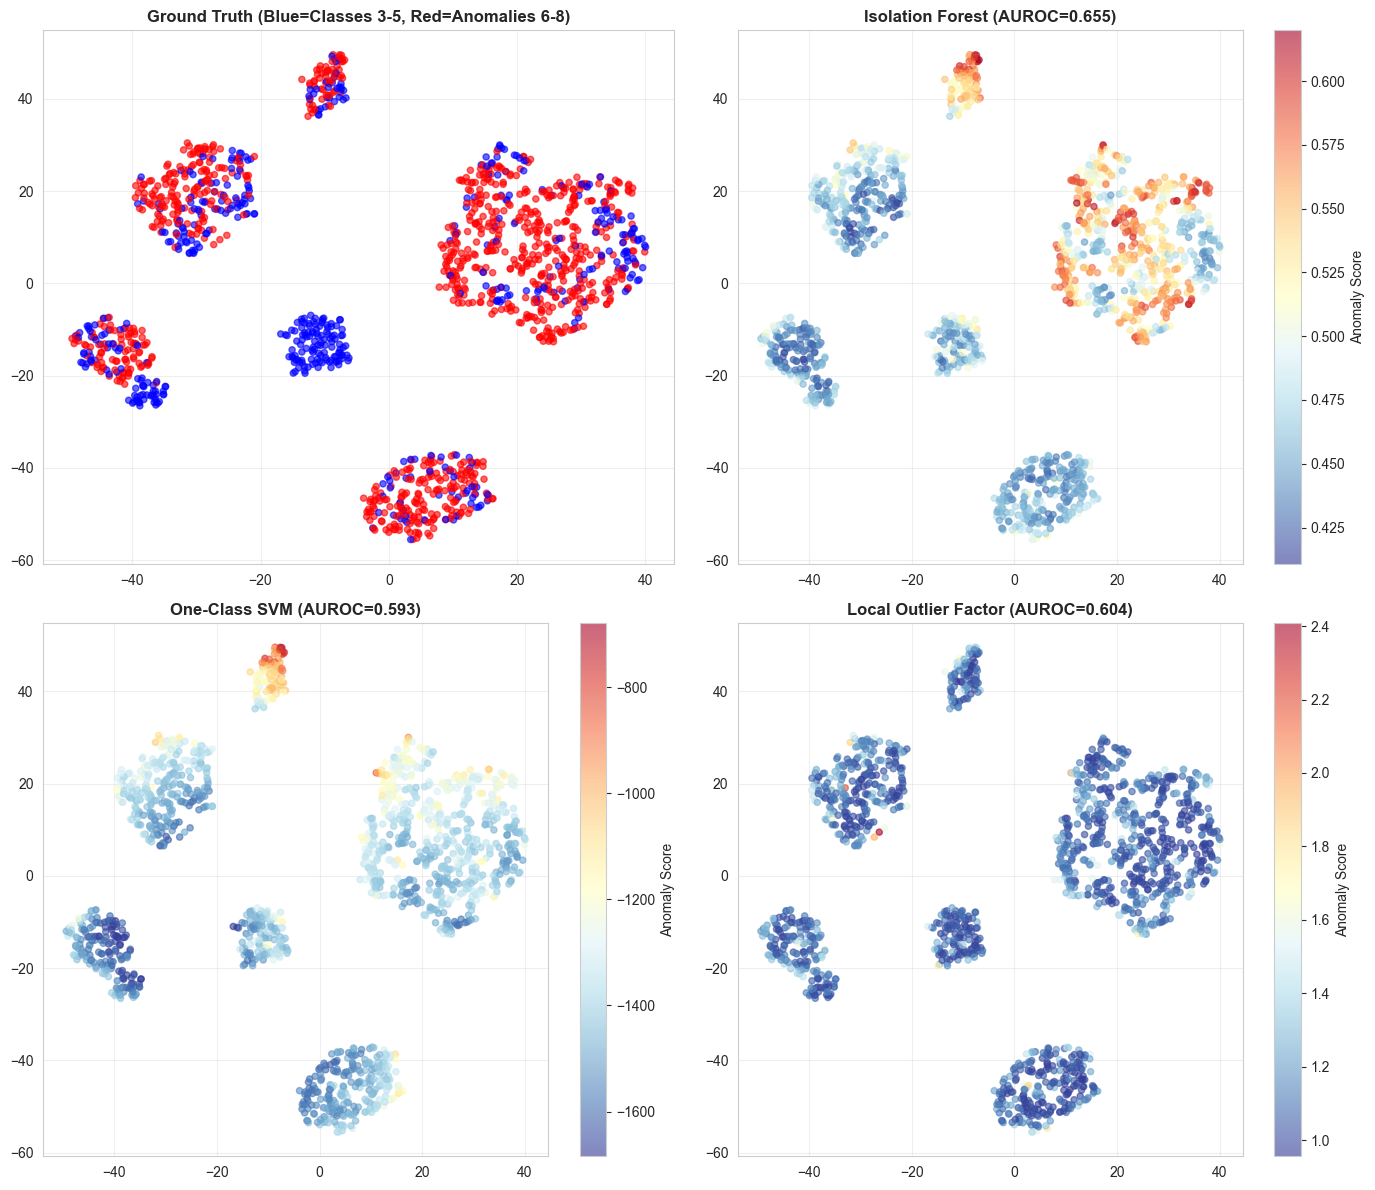

In [46]:
# EXPÉRIENCE : ENTRAÎNEMENT SUR CLASSES 3-5 UNIQUEMENT

# Filtrer uniquement classes 3-5 pour le train
mask_train_35 = np.isin(labels_id_train, [3, 4, 5])
signals_train_35 = signals_train[mask_train_35]
labels_train_35 = labels_id_train[mask_train_35]

# Filtrer test : garder classes 3-5 ET 6-8 (exclure 0-2)
mask_test_35 = np.isin(labels_id_test, [3, 4, 5, 6, 7, 8])
signals_test_35 = signals_test[mask_test_35]
labels_test_35 = labels_id_test[mask_test_35]

print(f"Train - Classes 3-5 uniquement: {len(labels_train_35)} samples")
print(f"Test - Classes 3-5 + anomalies: {len(labels_test_35)} samples")

# Preprocessing
X_train_processed_35 = preprocess_signals_amplitude(signals_train_35)
X_test_processed_35 = preprocess_signals_amplitude(signals_test_35)

# Extraction features
train_features_35 = []
test_features_35 = []
batch_size = 64

with torch.no_grad():
    for i in range(0, len(X_train_processed_35), batch_size):
        batch = torch.FloatTensor(X_train_processed_35[i:i+batch_size]).to(device)
        features = feature_extractor(batch)
        train_features_35.append(features.cpu().numpy())

    for i in range(0, len(X_test_processed_35), batch_size):
        batch = torch.FloatTensor(X_test_processed_35[i:i+batch_size]).to(device)
        features = feature_extractor(batch)
        test_features_35.append(features.cpu().numpy())

train_features_35 = np.vstack(train_features_35)
test_features_35 = np.vstack(test_features_35)
print(f"Train features: {train_features_35.shape}, Test features: {test_features_35.shape}")

# Ground truth
y_true_35 = (labels_test_35 > 5).astype(int)
print(f"Test - Normal (3-5): {(y_true_35==0).sum()}, Anomalies (6-8): {(y_true_35==1).sum()}")

# ANOMALY DETECTION

print("\n" + "="*60)
print("ISOLATION FOREST - Classes 3-5")
print("="*60)
iso_forest_35 = IsolationForest(contamination=0.3, random_state=42)
iso_forest_35.fit(train_features_35)
y_pred_if_35 = (iso_forest_35.predict(test_features_35) == -1).astype(int)
scores_if_35 = -iso_forest_35.score_samples(test_features_35)
auc_if_35 = roc_auc_score(y_true_35, scores_if_35)
print(f"AUROC: {auc_if_35:.4f}")
print(classification_report(y_true_35, y_pred_if_35, target_names=['Normal (3-5)', 'Anomalie (6-8)']))

print("\n" + "="*60)
print("ONE-CLASS SVM - Classes 3-5")
print("="*60)
oc_svm_35 = OneClassSVM(nu=0.3, kernel='rbf', gamma='auto')
oc_svm_35.fit(train_features_35)
y_pred_svm_35 = (oc_svm_35.predict(test_features_35) == -1).astype(int)
scores_svm_35 = -oc_svm_35.score_samples(test_features_35)
auc_svm_35 = roc_auc_score(y_true_35, scores_svm_35)
print(f"AUROC: {auc_svm_35:.4f}")
print(classification_report(y_true_35, y_pred_svm_35, target_names=['Normal (3-5)', 'Anomalie (6-8)']))

print("\n" + "="*60)
print("LOCAL OUTLIER FACTOR - Classes 3-5")
print("="*60)
lof_35 = LocalOutlierFactor(n_neighbors=20, contamination=0.3, novelty=True)
lof_35.fit(train_features_35)
y_pred_lof_35 = (lof_35.predict(test_features_35) == -1).astype(int)
scores_lof_35 = -lof_35.score_samples(test_features_35)
auc_lof_35 = roc_auc_score(y_true_35, scores_lof_35)
print(f"AUROC: {auc_lof_35:.4f}")
print(classification_report(y_true_35, y_pred_lof_35, target_names=['Normal (3-5)', 'Anomalie (6-8)']))

# ===== VISUALISATION T-SNE =====

print("\nCalcul du t-SNE pour visualisation...")
tsne_35 = TSNE(n_components=2, random_state=42)
test_features_2d_35 = tsne_35.fit_transform(test_features_35)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Ground truth
ax = axes[0, 0]
colors = ['blue' if 3 <= l <= 5 else 'red' for l in labels_test_35]
ax.scatter(test_features_2d_35[:, 0], test_features_2d_35[:, 1], c=colors, alpha=0.6, s=20)
ax.set_title('Ground Truth (Blue=Classes 3-5, Red=Anomalies 6-8)', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Isolation Forest
ax = axes[0, 1]
scatter = ax.scatter(test_features_2d_35[:, 0], test_features_2d_35[:, 1],
                     c=scores_if_35, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'Isolation Forest (AUROC={auc_if_35:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: One-Class SVM
ax = axes[1, 0]
scatter = ax.scatter(test_features_2d_35[:, 0], test_features_2d_35[:, 1],
                     c=scores_svm_35, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'One-Class SVM (AUROC={auc_svm_35:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: LOF
ax = axes[1, 1]
scatter = ax.scatter(test_features_2d_35[:, 0], test_features_2d_35[:, 1],
                     c=scores_lof_35, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'Local Outlier Factor (AUROC={auc_lof_35:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

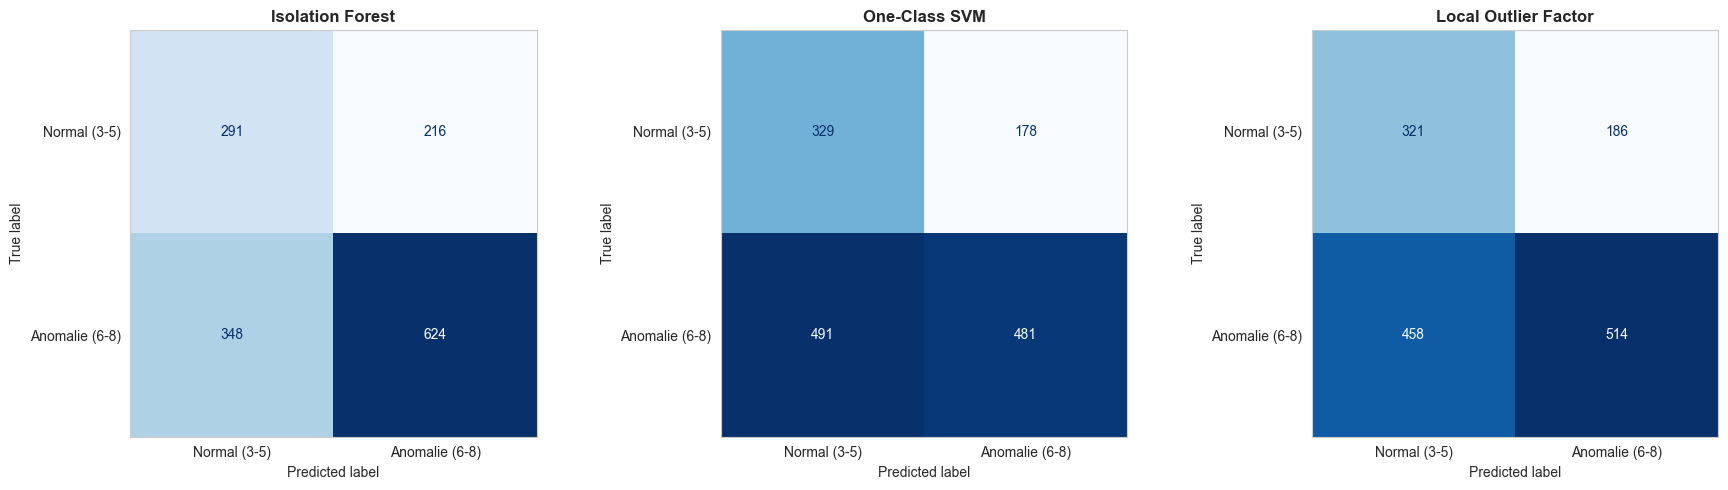

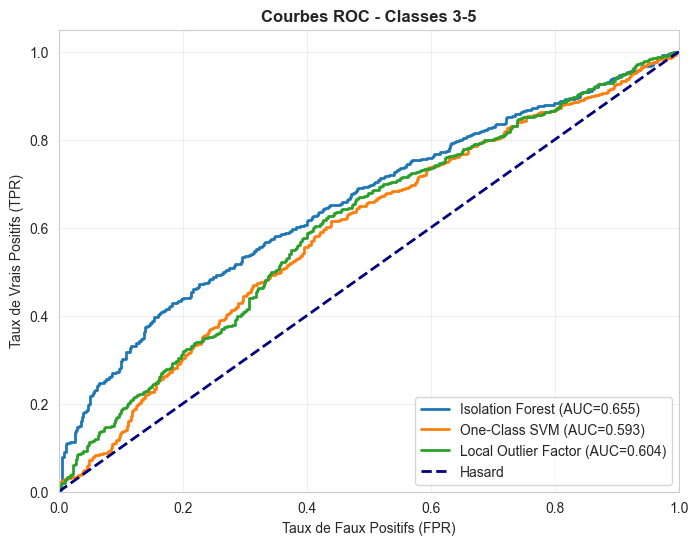


--- Métriques harmonisées ---
Isolation Forest     -> Précision: 0.743, Recall: 0.642, F1-score: 0.689
One-Class SVM        -> Précision: 0.730, Recall: 0.495, F1-score: 0.590
Local Outlier Factor -> Précision: 0.734, Recall: 0.529, F1-score: 0.615


In [64]:
# Liste des modèles / scores pour itération
models_35 = {
    "Isolation Forest": (y_pred_if_35, scores_if_35),
    "One-Class SVM": (y_pred_svm_35, scores_svm_35),
    "Local Outlier Factor": (y_pred_lof_35, scores_lof_35)
}

# -----------------------------
# Matrices de confusion (1 ligne)
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, (y_pred, _)) in enumerate(models_35.items()):
    cm = confusion_matrix(y_true_35, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal (3-5)','Anomalie (6-8)'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name, fontweight='bold')
    axes[i].grid(False)

plt.tight_layout()
plt.show()

# -----------------------------
# Courbes ROC
# -----------------------------
plt.figure(figsize=(8, 6))
for name, (_, y_score) in models_35.items():
    fpr, tpr, _ = roc_curve(y_true_35, y_score)
    auc_val = roc_auc_score(y_true_35, y_score)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc_val:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC - Classes 3-5', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# -----------------------------
# Précision, Recall, F1-score harmonisés
# -----------------------------
print("\n--- Métriques harmonisées ---")
for name, (y_pred, _) in models_35.items():
    precision = precision_score(y_true_35, y_pred)
    recall = recall_score(y_true_35, y_pred)
    f1 = f1_score(y_true_35, y_pred)
    print(f"{name:<20} -> Précision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")


Nous avons encore un problème similaire, peut importe la normalisation

On ne s'intéresse plus qu'à l'amplitude (1 canal) pour voir si cela peut nous aider à classifier puisque d'après nos analyses précédentes, les relations entre I et Q de nos anomalies ressemblent beaucoup à ce que l'on peut voir sur nos signaux normaux.

#### Modèle basé sur l'amplitude

Nous allons maintenant utiliser un modèle basé uniquement sur l'amplitude comme vu avec l'autoencoder.
L'idée est de voir si la proximité des représentations I/Q des anomalies et des relations brouille des différences qui sont observables uniquement sur l'amplitude

In [54]:

#On centre/réduit comme pour autoencoder

X_train_processed = preprocess_signals(signals_train)
X_valid_processed = preprocess_signals(signals_valid)
X_test_processed = preprocess_signals(signals_test)

print(f"\nNormalisation par énergie (AMPLITUDE 1 canal) appliquée:")
print(f"  Train shape: {X_train_processed.shape}")  # (N, 1, 2048)
print(f"  Valid shape: {X_valid_processed.shape}")
print(f"  Test shape: {X_test_processed.shape}")

#  DATALOADERS 

BATCH_SIZE = 32

tensor_x_train = torch.Tensor(X_train_processed).float()
tensor_y_train = torch.Tensor(labels_id_train).long()

tensor_x_valid = torch.Tensor(X_valid_processed).float()
tensor_y_valid = torch.Tensor(labels_id_valid).long()

tensor_x_test = torch.Tensor(X_test_processed).float()
tensor_y_test = torch.Tensor(labels_id_test).long()

train_loader = DataLoader(TensorDataset(tensor_x_train, tensor_y_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TensorDataset(tensor_x_valid, tensor_y_valid), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(tensor_x_test, tensor_y_test), batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataloaders créés:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Valid batches: {len(valid_loader)}")
print(f"  Test batches: {len(test_loader)}")



Normalisation par énergie (AMPLITUDE 1 canal) appliquée:
  Train shape: (30000, 1, 2048)
  Valid shape: (10000, 1, 2048)
  Test shape: (2000, 1, 2048)

Dataloaders créés:
  Train batches: 938
  Valid batches: 313
  Test batches: 63


In [55]:

#MODÈLE CNN POUR AMPLITUDE 

class SimpleCNN1D_Amplitude(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()

        # Input: [B, 1, 2048]
        self.features = nn.Sequential(
            # Bloc 1
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            # Bloc 2
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            # Bloc 3
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            # Bloc 4
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



In [56]:
# ENTRAÎNEMENT

LR = 1e-3
EPOCHS = 50

model_amplitude = SimpleCNN1D_Amplitude(n_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_amplitude.parameters(), lr=LR)

train_losses_amp = []
val_losses_amp = []
train_accuracies_amp = []
val_accuracies_amp = []
best_valid_acc_amp = 0.0

print("\nTraining CNN on AMPLITUDE (1 canal)...")
for epoch in range(EPOCHS):
    # Training
    model_amplitude.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for signals, labels in train_loader:
        signals = signals.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_amplitude(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Validation
    model_amplitude.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for signals, labels in valid_loader:
            signals = signals.to(device)
            labels = labels.to(device)

            outputs = model_amplitude(signals)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    avg_valid_loss = valid_loss / len(valid_loader)
    train_acc = 100 * train_correct / train_total
    valid_acc = 100 * valid_correct / valid_total

    train_losses_amp.append(avg_train_loss)
    val_losses_amp.append(avg_valid_loss)
    train_accuracies_amp.append(train_acc)
    val_accuracies_amp.append(valid_acc)

    if valid_acc > best_valid_acc_amp:
        best_valid_acc_amp = valid_acc
        torch.save(model_amplitude.state_dict(), 'best_cnn_amplitude_model.pth')

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.6f} | Valid Loss: {avg_valid_loss:.6f} | Train Acc: {train_acc:.2f}% | Valid Acc: {valid_acc:.2f}%")

print("\nTraining completed!")
print(f"Best validation accuracy: {best_valid_acc_amp:.2f}%")


Training CNN on AMPLITUDE (1 canal)...
Epoch [5/50] Train Loss: 0.589789 | Valid Loss: 0.601071 | Train Acc: 66.87% | Valid Acc: 67.13%
Epoch [10/50] Train Loss: 0.554376 | Valid Loss: 0.590391 | Train Acc: 68.51% | Valid Acc: 68.09%
Epoch [15/50] Train Loss: 0.523008 | Valid Loss: 0.575036 | Train Acc: 69.66% | Valid Acc: 68.69%
Epoch [20/50] Train Loss: 0.493815 | Valid Loss: 0.634025 | Train Acc: 70.64% | Valid Acc: 67.87%
Epoch [25/50] Train Loss: 0.457588 | Valid Loss: 0.725342 | Train Acc: 73.08% | Valid Acc: 66.23%
Epoch [30/50] Train Loss: 0.421277 | Valid Loss: 0.696199 | Train Acc: 74.60% | Valid Acc: 68.38%
Epoch [35/50] Train Loss: 0.383684 | Valid Loss: 0.880590 | Train Acc: 76.62% | Valid Acc: 67.07%
Epoch [40/50] Train Loss: 0.349587 | Valid Loss: 1.072475 | Train Acc: 78.48% | Valid Acc: 65.57%
Epoch [45/50] Train Loss: 0.334619 | Valid Loss: 1.163683 | Train Acc: 79.15% | Valid Acc: 66.96%
Epoch [50/50] Train Loss: 0.324068 | Valid Loss: 1.417853 | Train Acc: 80.12% |

Nous avons un peu d'overfitting, ce qui peut affecter nos résultats par la suite

C:\Users\Mathéo\AppData\Local\Temp\ipykernel_36068\1387569670.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_amplitude.load_state_dict(torch.load('best_cnn_amplit

Train preprocessed: (30000, 1, 2048)
Test preprocessed: (2000, 1, 2048)
Train features: (30000, 128), Test features: (2000, 128)
Test set - Normal: 1028, Anomalies: 972

ISOLATION FOREST - AMPLITUDE
AUROC: 0.6859
              precision    recall  f1-score   support

      Normal       0.65      0.59      0.61      1028
    Anomalie       0.60      0.66      0.63       972

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.63      0.62      0.62      2000


ONE-CLASS SVM - AMPLITUDE
AUROC: 0.7748
              precision    recall  f1-score   support

      Normal       0.73      0.64      0.68      1028
    Anomalie       0.66      0.75      0.70       972

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000


LOCAL OUTLIER FACTOR - AMPLITUDE
AUROC: 0.7019
              precision    recall  f1-score 

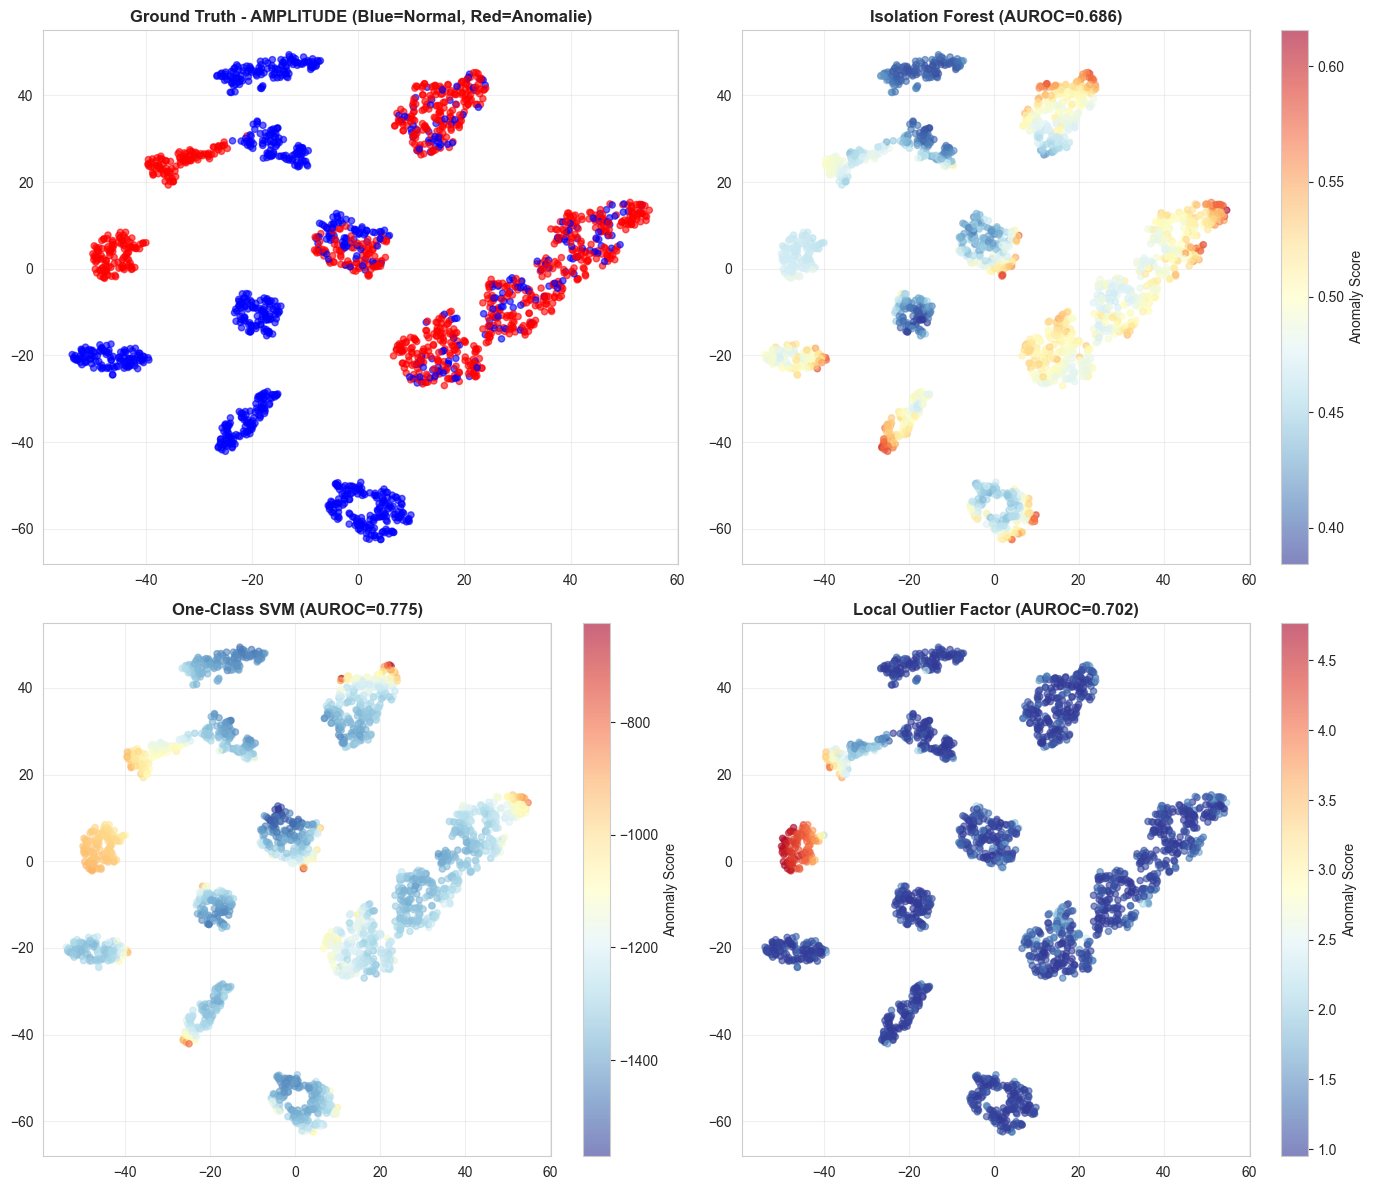


COMPARAISON : AMPLITUDE (1 canal) vs I/Q (2 canaux)
Méthode                   I/Q AUROC       AMPLITUDE AUROC
------------------------------------------------------------
Isolation Forest          0.5941          0.6859         
One-Class SVM             0.5919          0.7748         
LOF                       0.6107          0.7019         


In [57]:

# Charger le modèle entraîné sur AMPLITUDE
model_amplitude = SimpleCNN1D_Amplitude(n_classes=6).to(device)
model_amplitude.load_state_dict(torch.load('best_cnn_amplitude_model.pth'))
model_amplitude.eval()

# Feature Extractor (réutiliser la classe déjà définie)
feature_extractor_amp = FeatureExtractor(model_amplitude).to(device)
feature_extractor_amp.eval()

# Preprocessing AMPLITUDE (données déjà en mémoire)
X_train_processed_amp = preprocess_signals(signals_train)
X_test_processed_amp = preprocess_signals(signals_test)

print(f"Train preprocessed: {X_train_processed_amp.shape}")
print(f"Test preprocessed: {X_test_processed_amp.shape}")

# Extraction features
train_features_amp = []
test_features_amp = []
batch_size = 64

with torch.no_grad():
    for i in range(0, len(X_train_processed_amp), batch_size):
        batch = torch.FloatTensor(X_train_processed_amp[i:i+batch_size]).to(device)
        features = feature_extractor_amp(batch)
        train_features_amp.append(features.cpu().numpy())

    for i in range(0, len(X_test_processed_amp), batch_size):
        batch = torch.FloatTensor(X_test_processed_amp[i:i+batch_size]).to(device)
        features = feature_extractor_amp(batch)
        test_features_amp.append(features.cpu().numpy())

train_features_amp = np.vstack(train_features_amp)
test_features_amp = np.vstack(test_features_amp)

print(f"Train features: {train_features_amp.shape}, Test features: {test_features_amp.shape}")

# Ground truth
y_true_amp = (labels_id_test > 5).astype(int)
print(f"Test set - Normal: {(y_true_amp==0).sum()}, Anomalies: {(y_true_amp==1).sum()}")

# ANOMALY DETECTION

print("\n" + "="*60)
print("ISOLATION FOREST - AMPLITUDE")
print("="*60)
iso_forest_amp = IsolationForest(contamination=0.3, random_state=42)
iso_forest_amp.fit(train_features_amp)
y_pred_if_amp = (iso_forest_amp.predict(test_features_amp) == -1).astype(int)
scores_if_amp = -iso_forest_amp.score_samples(test_features_amp)
auc_if_amp = roc_auc_score(y_true_amp, scores_if_amp)
print(f"AUROC: {auc_if_amp:.4f}")
print(classification_report(y_true_amp, y_pred_if_amp, target_names=['Normal', 'Anomalie']))

print("\n" + "="*60)
print("ONE-CLASS SVM - AMPLITUDE")
print("="*60)
oc_svm_amp = OneClassSVM(nu=0.3, kernel='rbf', gamma='auto')
oc_svm_amp.fit(train_features_amp)
y_pred_svm_amp = (oc_svm_amp.predict(test_features_amp) == -1).astype(int)
scores_svm_amp = -oc_svm_amp.score_samples(test_features_amp)
auc_svm_amp = roc_auc_score(y_true_amp, scores_svm_amp)
print(f"AUROC: {auc_svm_amp:.4f}")
print(classification_report(y_true_amp, y_pred_svm_amp, target_names=['Normal', 'Anomalie']))

print("\n" + "="*60)
print("LOCAL OUTLIER FACTOR - AMPLITUDE")
print("="*60)
lof_amp = LocalOutlierFactor(n_neighbors=20, contamination=0.3, novelty=True)
lof_amp.fit(train_features_amp)
y_pred_lof_amp = (lof_amp.predict(test_features_amp) == -1).astype(int)
scores_lof_amp = -lof_amp.score_samples(test_features_amp)
auc_lof_amp = roc_auc_score(y_true_amp, scores_lof_amp)
print(f"AUROC: {auc_lof_amp:.4f}")
print(classification_report(y_true_amp, y_pred_lof_amp, target_names=['Normal', 'Anomalie']))

#VISUALISATION T-SNE

print("\nCalcul du t-SNE pour visualisation...")
tsne_amp = TSNE(n_components=2, random_state=42)
test_features_2d_amp = tsne_amp.fit_transform(test_features_amp)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Ground truth
ax = axes[0, 0]
colors = ['blue' if l <= 5 else 'red' for l in labels_id_test]
ax.scatter(test_features_2d_amp[:, 0], test_features_2d_amp[:, 1], c=colors, alpha=0.6, s=20)
ax.set_title('Ground Truth - AMPLITUDE (Blue=Normal, Red=Anomalie)', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Isolation Forest
ax = axes[0, 1]
scatter = ax.scatter(test_features_2d_amp[:, 0], test_features_2d_amp[:, 1],
                     c=scores_if_amp, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'Isolation Forest (AUROC={auc_if_amp:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: One-Class SVM
ax = axes[1, 0]
scatter = ax.scatter(test_features_2d_amp[:, 0], test_features_2d_amp[:, 1],
                     c=scores_svm_amp, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'One-Class SVM (AUROC={auc_svm_amp:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: LOF
ax = axes[1, 1]
scatter = ax.scatter(test_features_2d_amp[:, 0], test_features_2d_amp[:, 1],
                     c=scores_lof_amp, cmap='RdYlBu_r', alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax, label='Anomaly Score')
ax.set_title(f'Local Outlier Factor (AUROC={auc_lof_amp:.3f})', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===== COMPARAISON AMPLITUDE vs I/Q =====

print("\n" + "="*60)
print("COMPARAISON : AMPLITUDE (1 canal) vs I/Q (2 canaux)")
print("="*60)
print(f"{'Méthode':<25} {'I/Q AUROC':<15} {'AMPLITUDE AUROC':<15}")
print("-" * 60)
print(f"{'Isolation Forest':<25} {auc_if:<15.4f} {auc_if_amp:<15.4f}")
print(f"{'One-Class SVM':<25} {auc_svm:<15.4f} {auc_svm_amp:<15.4f}")
print(f"{'LOF':<25} {auc_lof:<15.4f} {auc_lof_amp:<15.4f}")

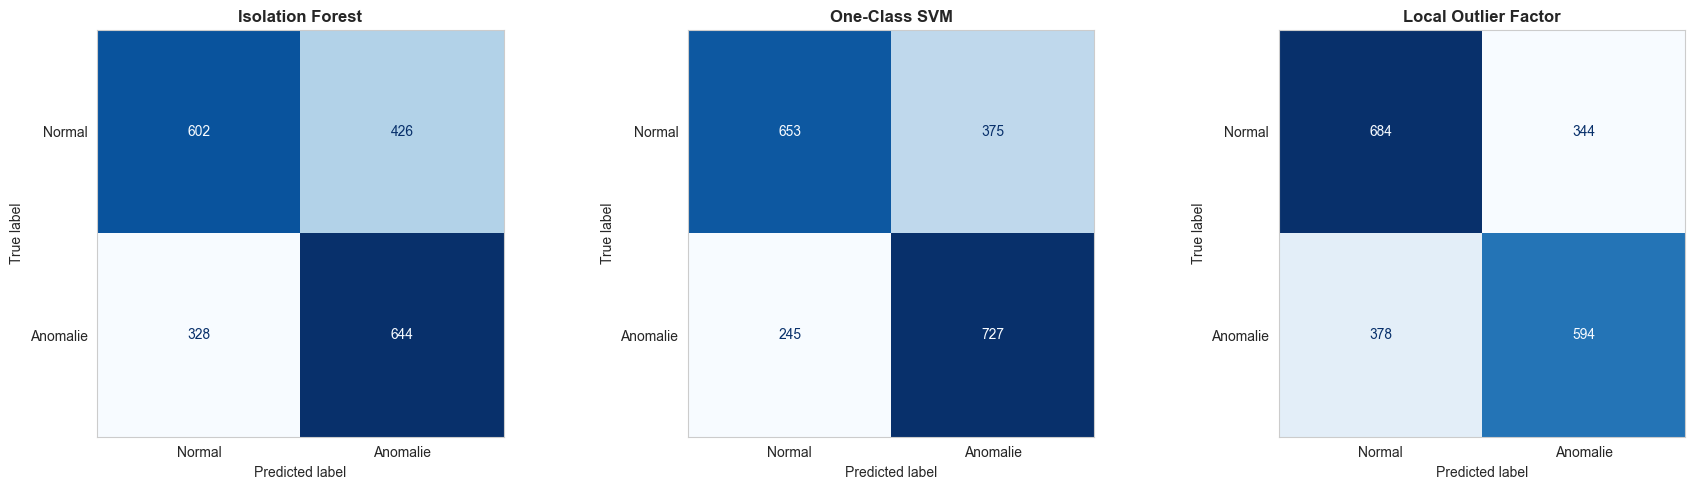

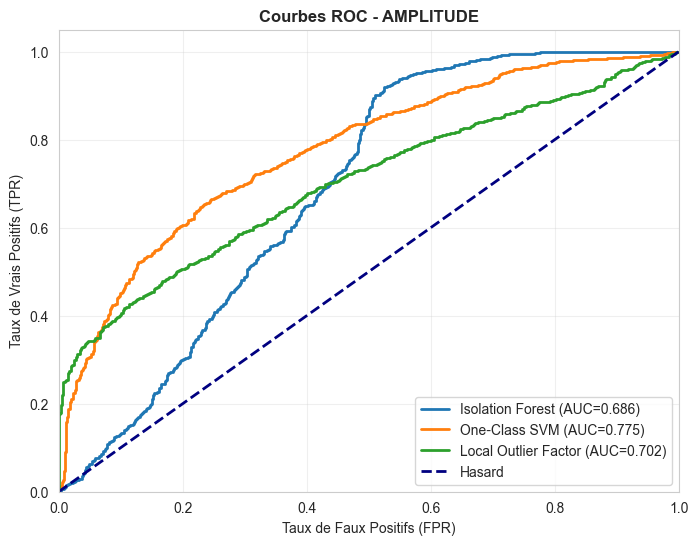


--- Métriques harmonisées (AMPLITUDE) ---
Isolation Forest          -> Précision: 0.602, Recall: 0.663, F1-score: 0.631
One-Class SVM             -> Précision: 0.660, Recall: 0.748, F1-score: 0.701
Local Outlier Factor      -> Précision: 0.633, Recall: 0.611, F1-score: 0.622


In [68]:
# Liste des modèles / scores pour itération (AMPLITUDE)
models_amp = {
    "Isolation Forest": (y_pred_if_amp, scores_if_amp),
    "One-Class SVM": (y_pred_svm_amp, scores_svm_amp),
    "Local Outlier Factor": (y_pred_lof_amp, scores_lof_amp)
}

# -----------------------------
# Matrices de confusion (1 ligne)
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, (y_pred, _)) in enumerate(models_amp.items()):
    cm = confusion_matrix(y_true_amp, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal','Anomalie'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name, fontweight='bold')
    axes[i].grid(False)

plt.tight_layout()
plt.show()

# -----------------------------
# Courbes ROC
# -----------------------------
plt.figure(figsize=(8, 6))
for name, (_, y_score) in models_amp.items():
    fpr, tpr, _ = roc_curve(y_true_amp, y_score)
    auc_val = roc_auc_score(y_true_amp, y_score)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc_val:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC - AMPLITUDE', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# -----------------------------
# Précision, Recall, F1-score harmonisés
# -----------------------------
print("\n--- Métriques harmonisées (AMPLITUDE) ---")
for name, (y_pred, _) in models_amp.items():
    precision = precision_score(y_true_amp, y_pred)
    recall = recall_score(y_true_amp, y_pred)
    f1 = f1_score(y_true_amp, y_pred)
    print(f"{name:<25} -> Précision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")


### Conclusion

La méthode retenue est la méthode de représentation des signaux dans l'espace latent d'un CNN entrainé sur un canal unique d'amplitude et la détection par One class SVM dans cet espace. Nous atteignons un AUC de 0.7748 avec notamment un rappel 0.75.
Le problème majeur s'est révélé être la proximité des classes 3 ,4 et 5 avec les anomalies.